In [1]:
import ROOT as r
import math
import array
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pandas as pd

#______________Add include directory_______________
current_dir = os.getcwd()
include_dir = os.path.join(current_dir, '../include')
sys.path.insert(0, include_dir)
#__________________________________________________
import ERROR
import CONFIG
import DBPARSE
from PXPY import *
from ASYMMETRY import *
from UTILITIES import *
from SIMFITS import DistributionFits
from ROOT import gStyle, TChain, TH1F, TCanvas, TLegend
import CORRECTIONS
import CALCULATE
import GETFF
from joblib import Parallel, delayed
import importlib
#importlib.reload(ASYMMETRY)

Welcome to JupyROOT 6.26/06


In [6]:
###############################################################################
###############################################################################

#NEEDS INELASTIC ASYMMETRY, NITROGEN CONTAMINATION

###############################################################################
###############################################################################

In [ ]:
hdx_sim_n

In [10]:
Pass="2"
config="3"
generic=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3/final{1}.npz")


In [448]:
W2min=CONFIG.Function_JSON("W2min",f"../config/Pass{Pass}/cuts{config}.cfg")
W2max=CONFIG.Function_JSON("W2max",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmin=CONFIG.Function_JSON("dxmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dxmax=CONFIG.Function_JSON("dxmax",f"../config/Pass{Pass}/cuts{config}.cfg")
dymin=CONFIG.Function_JSON("dymin",f"../config/Pass{Pass}/cuts{config}.cfg")
dymax=CONFIG.Function_JSON("dymax",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmin=CONFIG.Function_JSON("dybgmin",f"../config/Pass{Pass}/cuts{config}.cfg")
dybgmax=CONFIG.Function_JSON("dybgmax",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmin=CONFIG.Function_JSON("coinmin",f"../config/Pass{Pass}/cuts{config}.cfg")
coinmax=CONFIG.Function_JSON("coinmax",f"../config/Pass{Pass}/cuts{config}.cfg")
Q2=CONFIG.Function_JSON("Q2",f"../config/Pass{Pass}/cuts{config}.cfg")

#  "dxmin"	: -0.481,
#  "dxmax"	: 0.498, old gen2


print(f'W2min: {W2min}')
print(f'W2max: {W2max}')
print(f'dxmin: {dxmin}')
print(f'dxmax: {dxmax}')
print(f'dymin: {dymin}')
print(f'dymax: {dymax}')
print(f'dybgmin: {dybgmin}')
print(f'dybgmax: {dybgmax}')
print(f'Q2: {Q2}')
print(f'Coin Min: {coinmin} Coin Max: {coinmax}')

W2min=-1.9
#dymin=-1
#W2max=2

W2min: -1
W2max: 2
dxmin: -0.4
dxmax: 0.4
dymin: -0.5
dymax: 0.5
dybgmin: -1.3
dybgmax: 1.2
Q2: 6.83
Coin Min: 121 Coin Max: 134


In [449]:
#in GeV^2
m=.939565
muN=-1.9103
if config=="2":
    Q2=3
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    Q2=6.83
    #Q2=6.62 #seans number
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    Q2=9.82
    tau=Q2/(4*m**2)
    theta=35*pi/180

# Target Spin Direction

In [450]:
if config=="2":
    spintheta=59.34
    spinphi=1.84
if config=="3":
    spintheta=70.94
    spinphi=.51
if config=="4":
    spintheta=74.07
    spinphi=.55





In [451]:

fileNum=1
simconfig=config
if config=="4a" or config=="4b":
    simconfig="4"
genericSim=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN{simconfig}/simulation0.npz")
genericSimIN=np.load(f"/media/research/TOSHIBA EXT/GEn/NumpySim/GEN3/insimulation0.npz")

print(genericSim.files)
print(genericSimIN.files)



['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'ephi', 'trP', 'fnucl', 'weight']
['nu', 'Q2', 'W2', 'vz', 'vx', 'vy', 'dx', 'dy', 'eSH', 'ePS', 'etheta', 'trP', 'fnucl', 'weight', 'mc_sig', 'mc_sigOld', 'mc_sigPol', 'mc_BETA', 'mc_THETA']


In [452]:
#%load_ext memory_profiler
#%memit doit()


In [453]:
dataTarget = pd.read_csv('../DB/ProcessedHe3Pol.csv')
dataBeam = pd.read_csv('../DB/ProcessedBeamPol.csv')
target_run_num = dataTarget['Run Number'].to_numpy()
target_pol = dataTarget['Polarization'].to_numpy()
target_polE=dataTarget['Error'].to_numpy()
beam_run_num = dataBeam['Run Number'].to_numpy()
beam_pol = dataBeam['Polarization'].to_numpy()
beam_polE=dataBeam['Error'].to_numpy()

In [454]:
print("hehe")

hehe


In [455]:
%%time
if(len(generic["dx"])<3000000):
    
    useGrinch=True

    
    genericMaster = {}
    base_dir = f"/media/research/TOSHIBA EXT/GEn/NumpyData/Pass{Pass}/GEN{config}/He3"
    i = 0
    print(f"NumPy array directory = {base_dir}")
    while os.path.exists(f"{base_dir}/final{i}.npz"):
        print(f"Loading in file {i}")
        #if i>10:            #GPS
        #    break            #GPS
        file_path = f"{base_dir}/final{i}.npz"
        data = np.load(file_path)

        cut=(data["ePS"]>0.2)
        if Pass=="2":
            grinchcut=(data["grinch_clus_size"]>=2)&(data["grinch_clus_trackindex"]==0)
            antigrinchcut=(data["grinch_clus_size"]<2)|(data["grinch_clus_trackindex"]!=0)
            #pscut=(data["ePS"]>0) #GPS
            pscut=(data["ePS"]>0.2)
            if useGrinch:
                print("using grinch cut")
                #cut=antigrinchcut  #ANTIG
                cut=grinchcut
            else:
                print("using ps cut")
                cut=pscut
        for key in data.files:
            if key not in genericMaster:
                cut_data = data[key][cut]
                genericMaster[key] = cut_data

            else:
                cut_data = data[key][cut]
                genericMaster[key] = np.concatenate((genericMaster[key], cut_data))

        data.close()
        i += 1

    print(f"Loaded {i} files into genericMaster.")


CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs


In [456]:
generic=genericMaster

# Cuts

### Making the correct helicity

In [457]:
IHWP_IN=np.where(generic["IHWP"]==1)
helicity=generic["helicity"]
helicity[IHWP_IN]*=-1

### Cuts for data, bgsim, np sim 

In [458]:
bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]

In [459]:
wcut=(generic["W2"] < W2max)&(generic["W2"]>W2min) 
dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin) 
dxcut=(generic["dx"] < dxmax)&(generic["dx"]>dxmin) 
coincut=(coinmin < generic["coin_time"])&(generic["coin_time"] < coinmax)
epcut=abs(bbcalE/gemP-.95)<.25

runnumcut=generic["runnum"]>2165
fullcut=wcut & dycut & dxcut & coincut&epcut&runnumcut
fullcutfordx=wcut&dycut&coincut&epcut&runnumcut
accidentalcut=wcut&dycut&dxcut&epcut&runnumcut


anticoincut=(coinmin-8 > generic["coin_time"])|(generic["coin_time"] > coinmax+5)

hpluscut=helicity==1
hminuscut=helicity==-1

bgcut=(genericSimIN["W2"] < W2max)&(genericSimIN["W2"]>W2min)
antibgcut=(abs(generic["dy"])>1.2)&wcut&coincut
Simwcut=(genericSim["W2"] < W2max)&(genericSim["W2"]>W2min) 
Simdycut=(abs(genericSim["dy"]) < 0.5) 
Simdxcut=(genericSim["dx"] < dxmax)&(genericSim["dx"]>dxmin) 
Simfullcut=Simwcut & Simdycut & Simdxcut

InSimdxcut=(genericSimIN["dx"] < dxmax)&(genericSimIN["dx"]>dxmin)
InSimdycut=(genericSimIN["dy"] < dymax)&(genericSimIN["dy"]>dymin)



# Quick Preshower Check

In [460]:
"""#to check this, uncomment out the stuff in genericMaster creation tagged GPS

plt.figure(dpi=200)
grinchcut=(generic["BBgr_clus_size"]>=2)&(generic["BBgr_clus_trackindex"]==0)
antigrinchcut=(generic["BBgr_clus_size"]<2)|((generic["BBgr_clus_trackindex"]!=0))

base=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut],bins=100,range=(0,2),
              color='black',alpha=.7,label="Preshower with QE cuts")
antigrinchhist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&antigrinchcut],
           bins=100,range=(0,2),histtype='step',color='orange',linewidth=2,label="QE + antigrinch cut")

pshist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&(generic["ePS"]>.2)],
           color='red',histtype='step',linewidth=2,bins=100,range=(0,2),alpha=1,label="QE + ps cut")

grinchhist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&grinchcut],bins=100,
           color='dodgerblue',histtype='step',range=(0,2),alpha=1,linewidth=2,label="QE + grinch cut")
plt.legend(loc='upper right')
plt.title("Various bb.ps.e cuts")
plt.xlabel("GeV")

# Total events with just QE cuts (base)
base_count = np.sum(wcut & dxcut & dycut & coincut)

# Events passing grinch cut + QE
grinch_count = np.sum(wcut & dxcut & dycut & coincut & grinchcut)

# Events passing antigrinch + QE + preshower cut (ePS > 0.2)
antigrinch_ps_count = np.sum(wcut & dxcut & dycut & coincut & antigrinchcut & (generic["ePS"] > 0.2))

# Events passing just preshower cut (QE + ePS > 0.2)
pscut_count = np.sum(wcut & dxcut & dycut & coincut & (generic["ePS"] > 0.2))

print(f"PS cut: {pscut_count} (Mix of pion tail and electrons)")
print(f"PS cut + antigrinch: {antigrinch_ps_count} (hopefully just pions)")
print(f"Grinch cut: {grinch_count} (hopefully just good electrons)")
print(f"Base cut: {base_count}")
print(f"Grinch/(Base-piontail): {grinch_count/(base_count-antigrinch_ps_count):.4f}")
print(f"PS/Base: {pscut_count/(base_count):.4f}")
"""

'#to check this, uncomment out the stuff in genericMaster creation tagged GPS\n\nplt.figure(dpi=200)\ngrinchcut=(generic["BBgr_clus_size"]>=2)&(generic["BBgr_clus_trackindex"]==0)\nantigrinchcut=(generic["BBgr_clus_size"]<2)|((generic["BBgr_clus_trackindex"]!=0))\n\nbase=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut],bins=100,range=(0,2),\n              color=\'black\',alpha=.7,label="Preshower with QE cuts")\nantigrinchhist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&antigrinchcut],\n           bins=100,range=(0,2),histtype=\'step\',color=\'orange\',linewidth=2,label="QE + antigrinch cut")\n\npshist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&(generic["ePS"]>.2)],\n           color=\'red\',histtype=\'step\',linewidth=2,bins=100,range=(0,2),alpha=1,label="QE + ps cut")\n\ngrinchhist=plt.hist(generic["ePS"][wcut&dxcut&dycut&coincut&grinchcut],bins=100,\n           color=\'dodgerblue\',histtype=\'step\',range=(0,2),alpha=1,linewidth=2,label="QE + grinch cut")\nplt.legend(loc

# Data Histograms

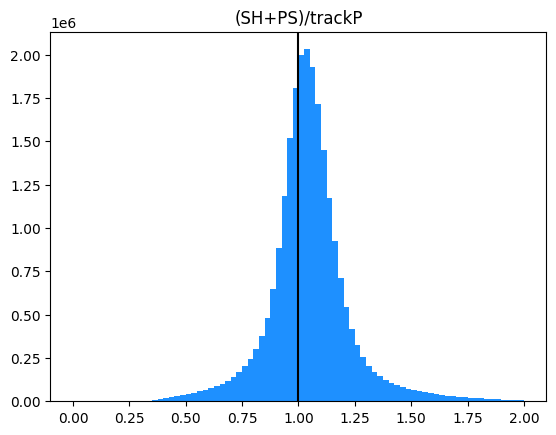

In [461]:
d=plt.hist(bbcalE/gemP,bins=80,range=(0,2),color='dodgerblue')
#d=plt.hist(bbcalE/gemP,bins=80,range=(0,2),alpha=.1)

plt.axvline(1,color='black')
plt.title("(SH+PS)/trackP")

epcut=abs(bbcalE/gemP-.95)<.25

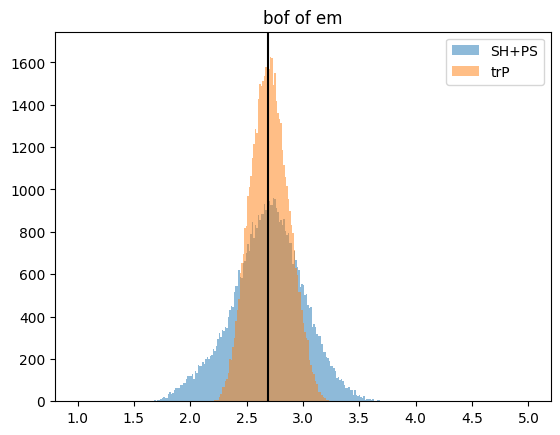

In [462]:
d=plt.hist(bbcalE[fullcut],bins=300,label='SH+PS',range=(1,5),alpha=.5)
d=plt.hist(gemP[fullcut],bins=300,label='trP',range=(1,5),alpha=.5)
plt.title("bof of em")
plt.legend(loc='upper right')
plt.axvline(2.69,color='black')

13

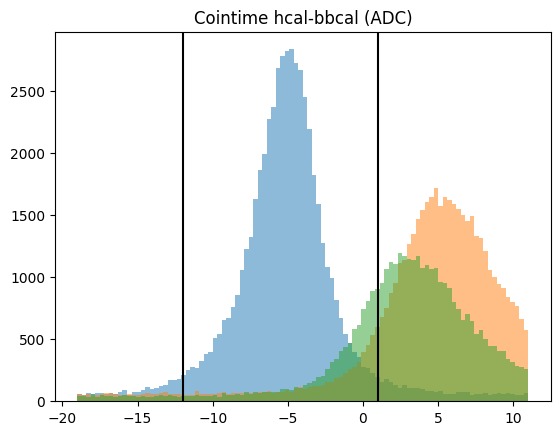

In [463]:
tester=generic["HCALtw"][accidentalcut]-generic["sbs_rftime"][accidentalcut]-generic["HODOmeantime"][accidentalcut]+generic["bb_rftime"][accidentalcut]


d=plt.hist(generic["coin_time"][accidentalcut]-133,bins=100,range=(coinmin-10-130,coinmax+10-133),alpha=.5)

d=plt.hist(generic["HCALtw"][accidentalcut]+10-generic["HODOmeantime"][accidentalcut],
           bins=100,range=(coinmin-10-130,coinmax+10-133),alpha=.5)
d=plt.hist(tester+5,
           bins=100,range=(coinmin-10-130,coinmax+10-133),alpha=.5)
plt.title("Cointime hcal-bbcal (ADC)")
plt.axvline(coinmin-133,color='black')
plt.axvline(coinmax-133,color='black')
coinmax-coinmin

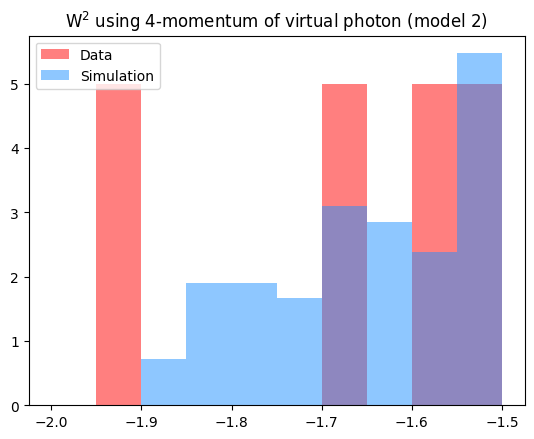

In [554]:
dataW2 = generic["W2"][dycut & dxcut & coincut & epcut]
simW2 = genericSim["W2"][neutroncut & Simwcut & Simdycut]

# Plot
plt.hist(dataW2, bins=10, range=(-2,-1.5), density=True, alpha=0.5, color='red', label='Data')
plt.hist(simW2, bins=10, range=(-2,-1.5), density=True, alpha=0.5, color='dodgerblue', label='Simulation')

#plt.axvline(W2min+.5, color='black')
#plt.axvline(W2max, color='black')
plt.title(r"W$^2$ using 4-momentum of virtual photon (model 2)")
plt.legend()
weirdW2=(generic["W2"]>-2)&(generic["W2"]<-1.8)

Text(0.5, 1.0, '$\\Delta X$')

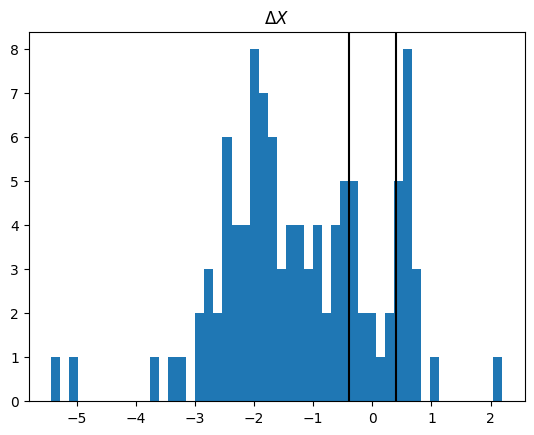

In [556]:

plt.axvline(dxmin,color='black')
plt.axvline(dxmax,color='black')
plt.title(r"$\Delta X$")

Text(0.5, 1.0, '$\\Delta y$')

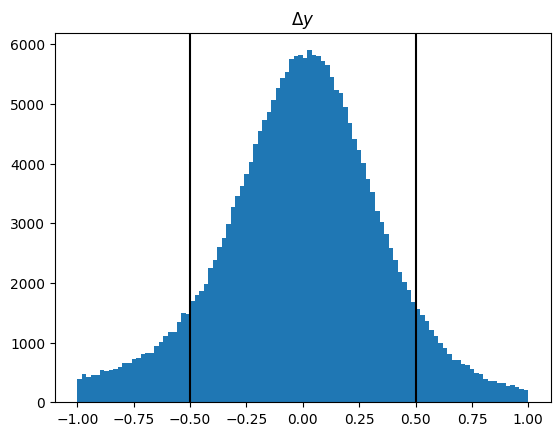

In [466]:
d=plt.hist(genericSim["dy"],bins=100,range=(-1,1))
plt.axvline(dymin,color='black')
plt.axvline(dymax,color='black')
plt.title(r"$\Delta y$")

In [467]:
 #d=plt.hist(generic["dx"][coincut&wcut&dycut&grinchcut],bins=100)
#plt.title(r"$\Delta Y$")

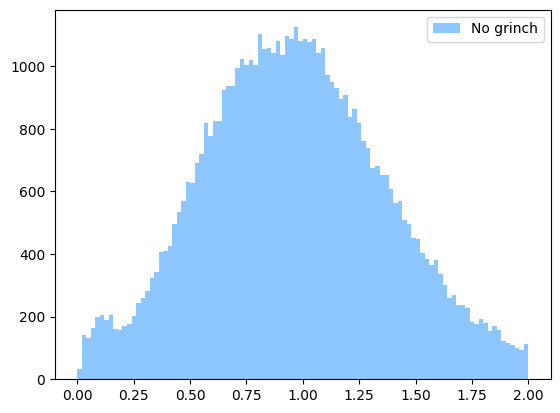

In [468]:
if Pass=="2":
    d=plt.hist(generic["ePS"][coincut&dxcut&dycut&wcut],bins=100,range=(0,2),label="No grinch",color='dodgerblue',alpha=.5)
    #d=plt.hist(generic["ePS"][grinchcut],bins=100,range=(0,2),label="Grinch cut",color='red',alpha=.5)
    #plt.yscale('log')
    plt.legend(loc='upper right')
    #plt.ylim(0,400000)

# Simulation Histograms

### Quasi Elastic

In [469]:
protoncut=genericSim["fnucl"]==1
neutroncut=genericSim["fnucl"]==0
weight=genericSim["weight"]

In [470]:
len(genericSim["dx"][protoncut&Simdycut])

119814

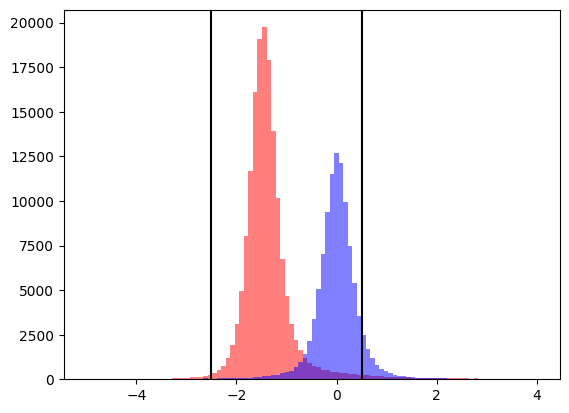

In [471]:
d=plt.hist(genericSim["dx"][protoncut],bins=100,range=(-5,4),alpha=.5,color='red')
d=plt.hist(genericSim["dx"][neutroncut],bins=100,range=(-5,4),alpha=.5,color='blue')
plt.axvline(-2.5,color='black')
plt.axvline(dymax,color='black')

In [472]:
#hdx_sim_p=plt.hist(genericSim["dx"][protoncut&Simwcut&Simdycut],range=(-5,4),
#                   bins=100,color='red',weights=weight[protoncut&Simwcut&Simdycut],alpha=.5)
#hdx_sim_n=plt.hist(genericSim["dx"][neutroncut&Simwcut&Simdycut],range=(-5,4),
 #                  bins=100,color='dodgerblue',weights=weight[neutroncut&Simwcut&Simdycut],alpha=.5)
hdx_sim_n=np.histogram(genericSim["dx"],range=(-.4,.4),
                   bins=100)


### Inelastic

In [473]:
Mp=.938

In [474]:
sigma=genericSimIN["mc_sig"]
sigmaold=genericSimIN["mc_sigOld"]
sigmapol=genericSimIN["mc_sigPol"]
THETA=genericSimIN["mc_THETA"]
BETA=genericSimIN["mc_BETA"]
Q2_in=genericSimIN["Q2"]
nu_in=genericSimIN["nu"]
W2_in=genericSimIN["W2"]
x_in  = Q2_in/(2.0*Mp*nu_in)
dy_in=genericSimIN["dy"]
dx_in=genericSimIN["dx"]

dy_incut=(dy_in<dymax)&(dy_in>dymin)
bgcut=(W2_in<W2max)&(W2_in>W2min)#&(abs(dy_in) < 0.5)#&(sigma<1e-39)##&(Q2<6.1)#
sigmacut=(sigma>6e-39)
goodsigmacut=sigma<.4e-37

goodsigmaoldcut=(sigmaold<.4e-32)&(sigmaold>1e-34)


#factor of hbar*c
hbarc=3.89e-28
#cm^2 to nb converter
cm2nb=1e33
einterval=10.5



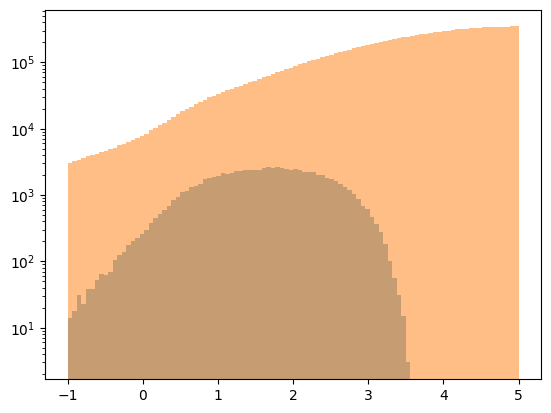

In [475]:
d=plt.hist(generic["W2"][dycut&coincut&dxcut],bins=100,range=(-1,5),alpha=.5)
d=plt.hist(generic["W2"],bins=100,range=(-1,5),alpha=.5)
plt.yscale("log")

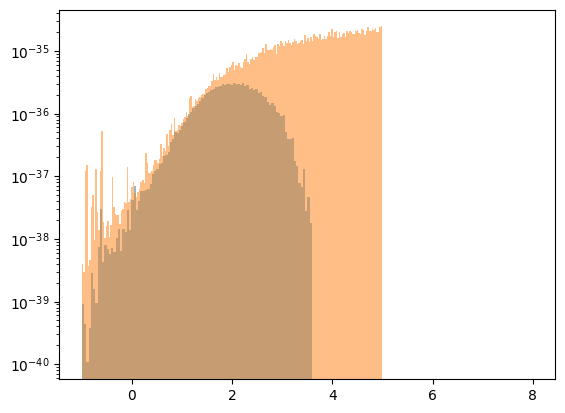

In [476]:
d=plt.hist(genericSimIN["W2"][dy_incut&goodsigmacut],bins=200,range=(-1,8),
           weights=sigma[dy_incut&goodsigmacut],alpha=.5)
d=plt.hist(genericSimIN["W2"],bins=200,range=(-1,5),alpha=.5,weights=sigma)
plt.yscale("log")

In [477]:
print(f"W2 min,max: {W2min},{W2max}")
print(f"abs(dy)<.5")
print("ePS>.2")

W2 min,max: -1.9,2
abs(dy)<.5
ePS>.2


Text(0, 0.5, 'x_bj')

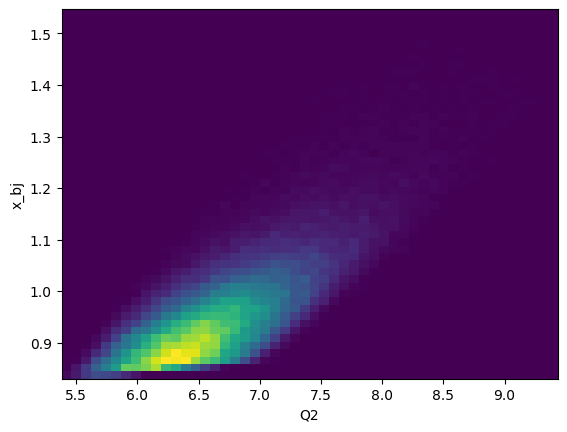

In [478]:
d=plt.hist2d(Q2_in[bgcut],x_in[bgcut],bins=50)
plt.xlabel("Q2")
plt.ylabel("x_bj")

Text(0.5, 1.0, 'Cuts: W2 min,max: -1.9,2 \n abs(dy)<.5 \nePS>.2')

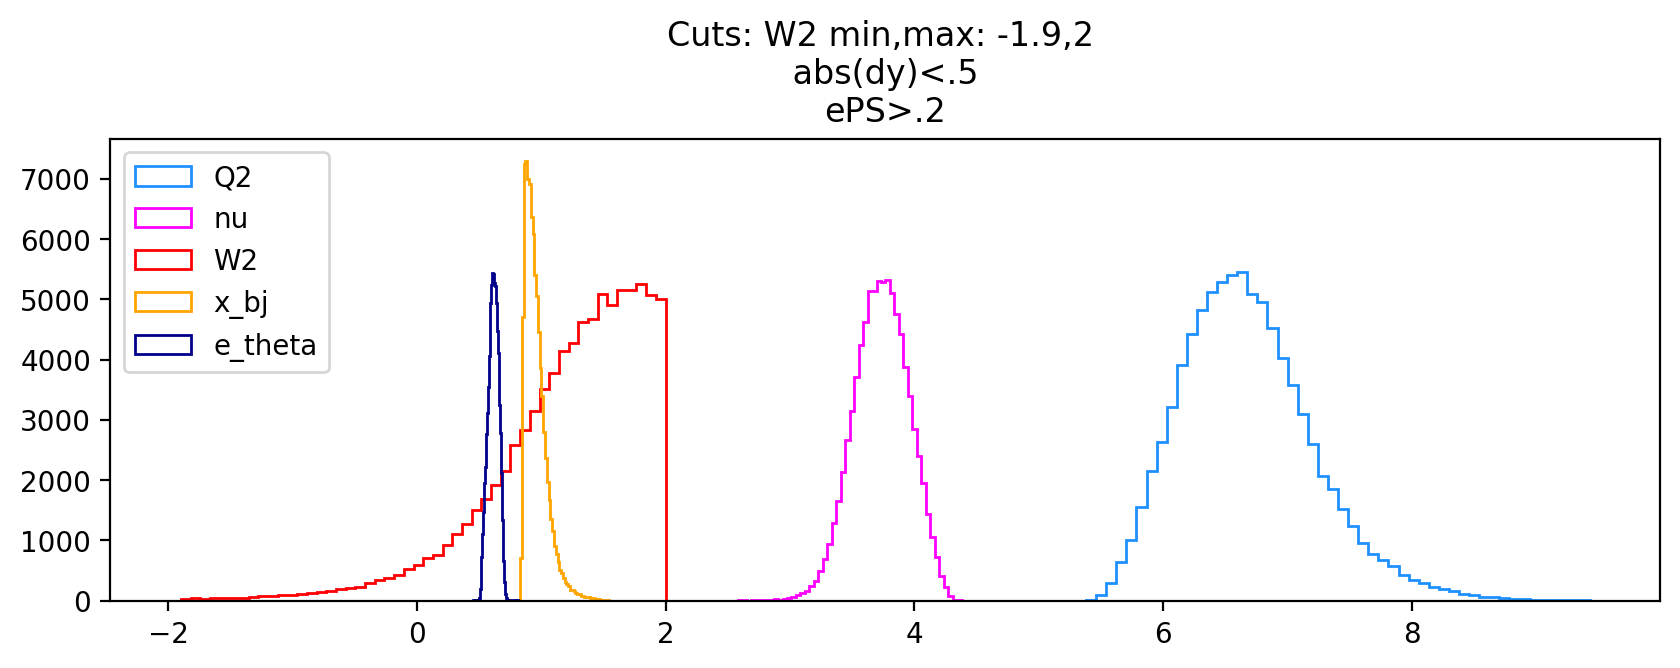

In [479]:
plt.figure(figsize=(10,3),dpi=200)

d=plt.hist(Q2_in[bgcut],bins=50,label='Q2',histtype='step',color='dodgerblue')
d=plt.hist(nu_in[bgcut],bins=50,label='nu',histtype='step',color='magenta')
d=plt.hist(W2_in[bgcut],bins=50,label='W2',histtype='step',color='red')
d=plt.hist(x_in[bgcut],bins=50,label='x_bj',histtype='step',color='orange')
d=plt.hist(THETA[bgcut],bins=50,label='e_theta',histtype='step',color='darkblue')
plt.legend(loc='upper left')
plt.title(f"Cuts: W2 min,max: {W2min},{W2max} \n abs(dy)<.5 \nePS>.2")
#plt.xlabel("GeV^2 - GeV - Radians ")

Text(0.5, 1.0, 'Cuts: W2 min,max: -1.9,2 \n abs(dy)<.5 \nePS>.2 \nsig<6e-39')

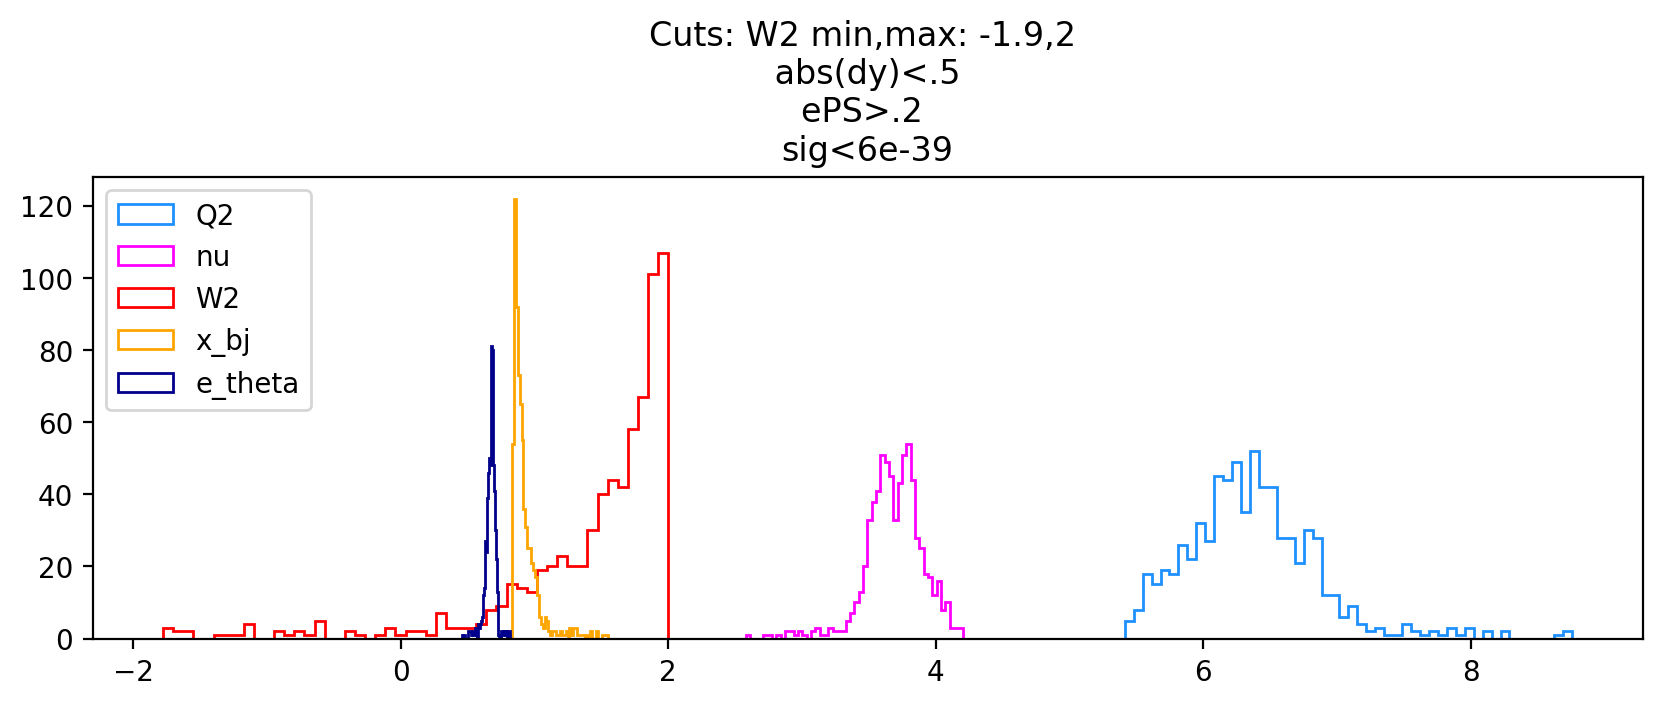

In [480]:
plt.figure(figsize=(10,3),dpi=200)

d=plt.hist(Q2_in[(bgcut)&(sigmacut)],bins=50,label='Q2',histtype='step',color='dodgerblue')
d=plt.hist(nu_in[(bgcut)&(sigmacut)],bins=50,label='nu',histtype='step',color='magenta')
d=plt.hist(W2_in[(bgcut)&(sigmacut)],bins=50,label='W2',histtype='step',color='red')
d=plt.hist(x_in[(bgcut)&(sigmacut)],bins=50,label='x_bj',histtype='step',color='orange')
d=plt.hist(THETA[(bgcut)&(sigmacut)],bins=50,label='e_theta',histtype='step',color='darkblue')
plt.legend(loc='upper left')
plt.title(f"Cuts: W2 min,max: {W2min},{W2max} \n abs(dy)<.5 \nePS>.2 \nsig<6e-39")
#plt.xlabel("GeV^2 - GeV - Radians ")

Text(0.5, 1.0, 'BOSTED UNPOL NO CUTS')

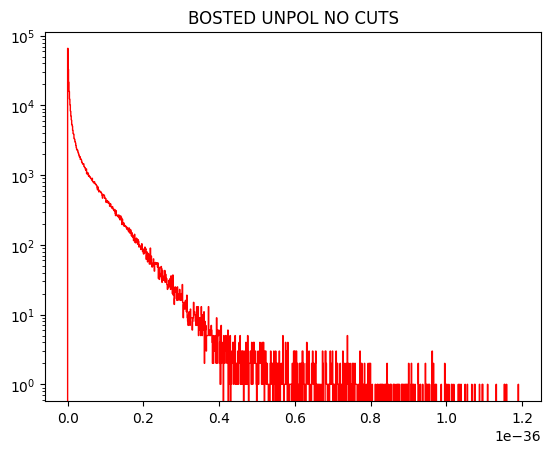

In [481]:
d=plt.hist(sigma,bins=1000,histtype='step',color='red')
plt.yscale('log')
plt.title("BOSTED UNPOL NO CUTS")

Text(0.5, 1.0, 'ZHENG UNPOL NO CUTS')

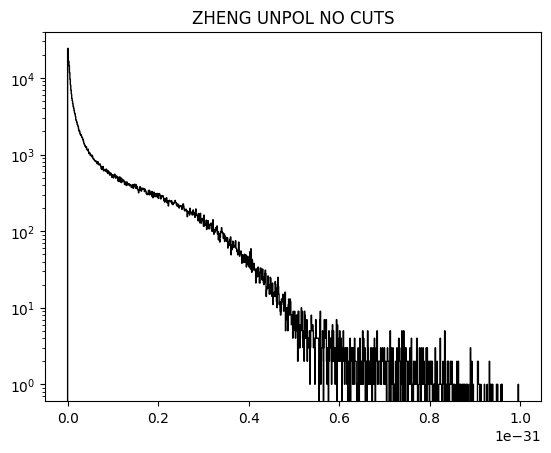

In [482]:
d=plt.hist(sigmaold,bins=1000,histtype='step',color='black')
plt.yscale("log")
plt.title("ZHENG UNPOL NO CUTS")

Text(3e-37, 5, 'Events w sig <6e-39: 72600')

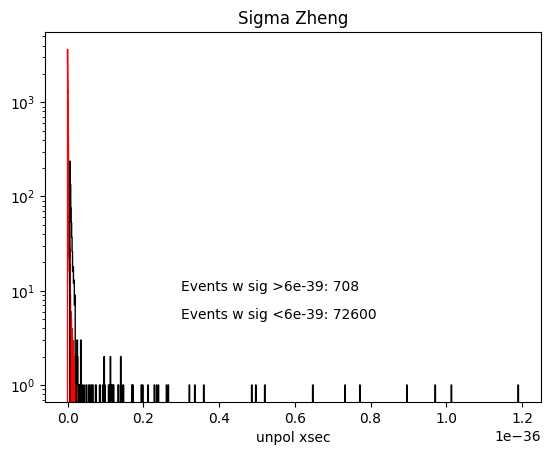

In [483]:
d=plt.hist(sigma[(bgcut)&(goodsigmacut)],bins=1000,histtype='step',color='red')
d=plt.hist(sigma[(bgcut)&(sigmacut)],bins=1000,histtype='step',color='black')
plt.title("Sigma Zheng")
plt.yscale('log')
plt.xlabel("unpol xsec")
plt.text(3e-37,10,f"Events w sig >6e-39: {len(sigma[bgcut&(sigmacut)])}")
plt.text(3e-37,5,f"Events w sig <6e-39: {len(sigma[(bgcut)&(sigma<2e-39)])}")

Text(0.5, 1.0, 'Zheng Unpol w/cuts and sig<6e-39')

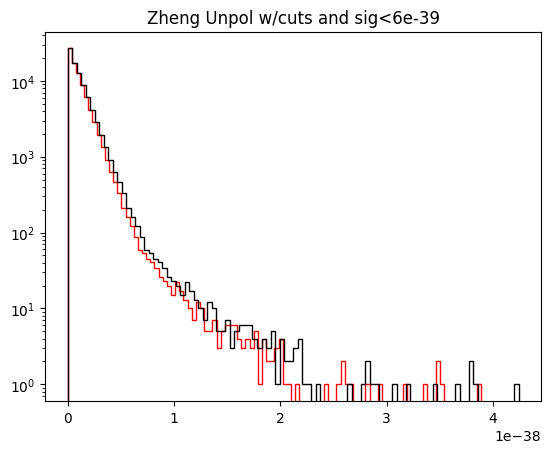

In [484]:
d=plt.hist(sigma[(bgcut)&(goodsigmacut)],bins=100,histtype='step',color='red')
d=plt.hist(genericSimIN["weight"][(bgcut)&(goodsigmacut)]*5.1,bins=100,histtype='step',color='black')

plt.yscale("log")
plt.title("Zheng Unpol w/cuts and sig<6e-39")

Text(0.5, 0, 'unpol xsec')

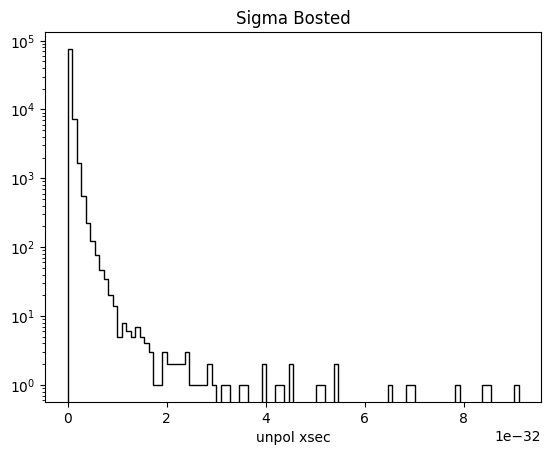

In [485]:
d=plt.hist(sigmaold[(bgcut)],bins=100,histtype='step',color='black')
plt.title("Sigma Bosted")
plt.yscale("log")
plt.xlabel("unpol xsec")

Text(0.5, 0, 'unpol xsec')

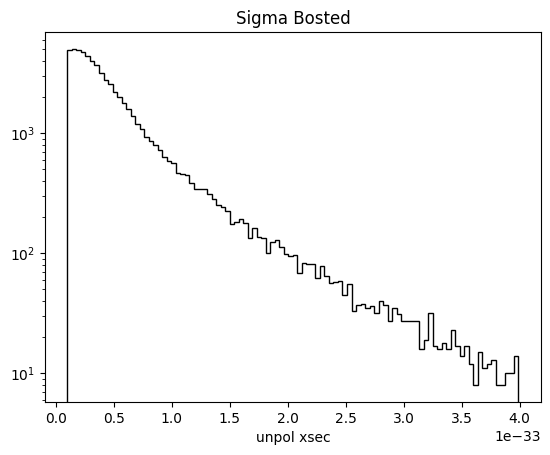

In [486]:
d=plt.hist(sigmaold[bgcut&(goodsigmaoldcut)],bins=100,histtype='step',color='black')
plt.title("Sigma Bosted")
plt.yscale("log")
plt.xlabel("unpol xsec")

/tmp/ipykernel_14063/435673948.py:1: RuntimeWarning: divide by zero encountered in divide
  d=plt.hist((sigma*cm2nb*hbarc)/sigmaold,


Text(0.5, 1.0, 'unpol xsec 3*Zheng/Bosted')

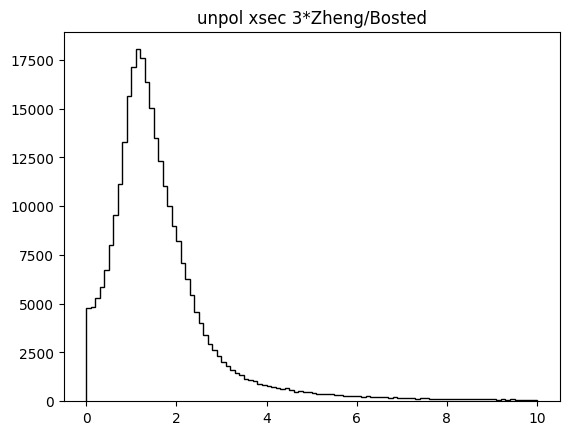

In [487]:
d=plt.hist((sigma*cm2nb*hbarc)/sigmaold,
           bins=100,range=(0,10),histtype='step',color='black',linewidth=1)
plt.title("unpol xsec 3*Zheng/Bosted")

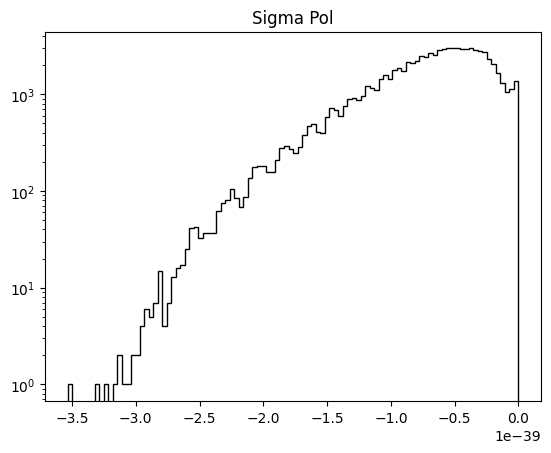

In [488]:
d=plt.hist(sigmapol[bgcut],bins=100,histtype='step',color='black')
plt.title("Sigma Pol")
plt.yscale("log")

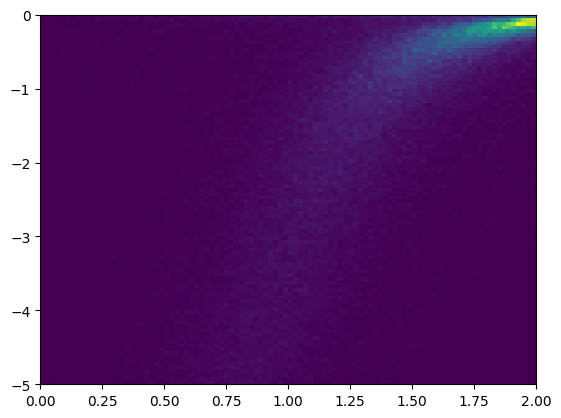

In [489]:
d=plt.hist2d(genericSimIN["W2"][bgcut],sigmapol[bgcut]/(sigma[bgcut]),
             range=((0,W2max),(-5,0)),bins=100)


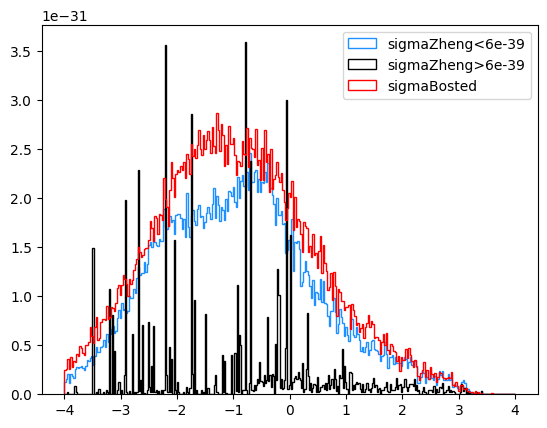

In [490]:

hdx_sim_bg=plt.hist(genericSimIN["dx"][(bgcut)&(goodsigmacut)],
                    range=(-4,4),bins=300,weights=sigma[(bgcut)&(goodsigmacut)]*3e5,
                    histtype='step',color='dodgerblue',label="sigmaZheng<6e-39")
hdx_sim_bg=plt.hist(genericSimIN["dx"][bgcut&(sigmacut)],range=(-4,4),bins=400,weights=sigma[bgcut&(sigmacut)]*3e5,
                    histtype='step',color='black',label='sigmaZheng>6e-39')
hdx_sim_bg=plt.hist(genericSimIN["dx"][bgcut&(goodsigmaoldcut)],
                    range=(-4,4),bins=300,weights=sigmaold[bgcut&(goodsigmaoldcut)],
                    histtype='step',color='red',label='sigmaBosted')
plt.legend(loc='upper right')


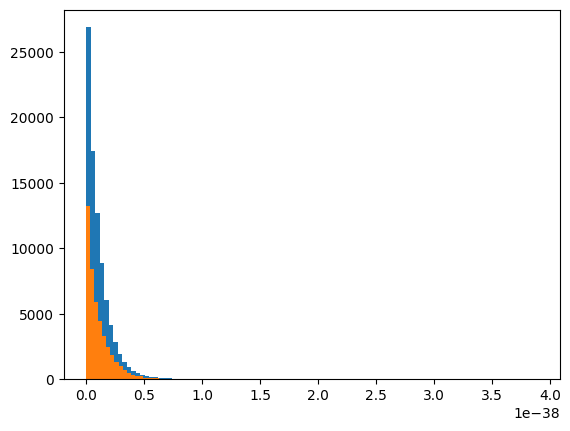

In [491]:
d=plt.hist(sigma[bgcut&goodsigmacut],bins=100)
d=plt.hist(sigma[bgcut&goodsigmacut&(dy_in<dymax)&(dy_in>dymin)],bins=100)

Text(0.5, 1.0, "Theta angle between S and e'")

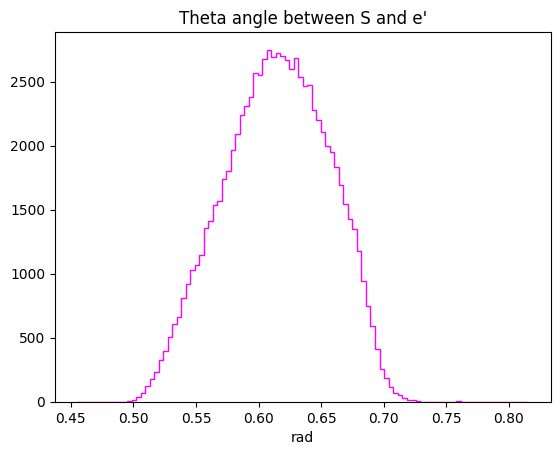

In [492]:
d=plt.hist(THETA[bgcut],bins=100,histtype='step',color='magenta')
plt.xlabel("rad")
plt.title("Theta angle between S and e'")


In [493]:
#d=plt.hist(sigmaold[bgcut&goodsigmacut],bins=100)
#d=plt.hist(sigmapol[bgcut&goodsigmacut],bins=100)

Asymmetry (pol_counts/(2*unpol_counts)) from -0.4 to 0.4: -0.0035


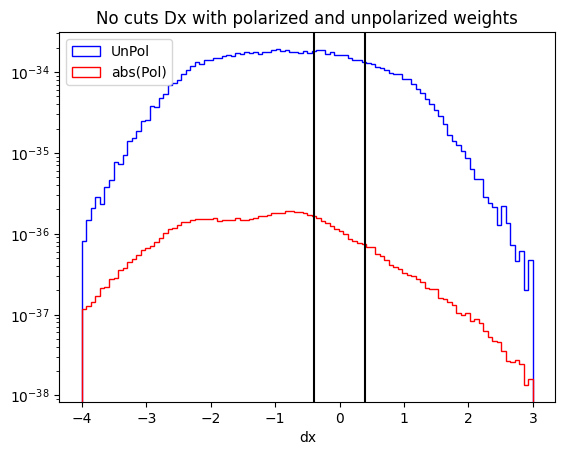

In [494]:

d_unpol=plt.hist(dx_in,bins=100,range=(-4,3),weights=sigma,histtype='step',color='blue',label=("UnPol"))
d_pol=plt.hist(dx_in,bins=100,range=(-4,3),weights=abs(sigmapol),histtype='step',color='red',label='abs(Pol)')
plt.axhline(0,color='black')
plt.title("No cuts Dx with polarized and unpolarized weights")
plt.legend(loc='upper left')
plt.xlabel("dx")
plt.yscale('log')
plt.axvline(dxmin,color='black')
plt.axvline(dxmax,color='black')



bin_edges = d_unpol[1]
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

# Boolean mask for bins between dxmin and dxmax
mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

# Sum the counts (weights) inside the selected range
unpol_counts = np.sum(d_unpol[0][mask])
pol_counts = np.sum(d_pol[0][mask])

print(f"Asymmetry (pol_counts/(2*unpol_counts)) from {dxmin} to {dxmax}: {-pol_counts/(2*unpol_counts):.4f}")

Asymmetry from -0.4 to 0.4: -0.3054


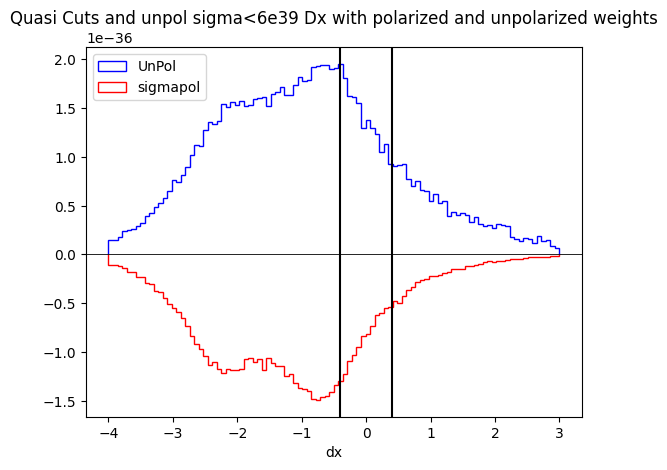

In [495]:

d_unpol=plt.hist(dx_in[bgcut&goodsigmacut]
           ,bins=100,range=(-4,3),weights=sigma[bgcut&goodsigmacut]
           ,histtype='step',color='blue',label=("UnPol"))
d_pol=plt.hist(dx_in[bgcut&goodsigmacut]
           ,bins=100,range=(-4,3),weights=sigmapol[bgcut&goodsigmacut]
           ,histtype='step',color='red',label='sigmapol')
plt.axhline(0,color='black',linewidth=.6)
plt.title("Quasi Cuts and unpol sigma<6e39 Dx with polarized and unpolarized weights")
plt.legend(loc='upper left')
plt.xlabel("dx")
plt.axvline(dxmin,color='black')
plt.axvline(dxmax,color='black')


bin_edges = d_unpol[1]
bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])

# Boolean mask for bins between dxmin and dxmax
mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

# Sum the counts (weights) inside the selected range
unpol_counts = np.sum(d_unpol[0][mask])
pol_counts = np.sum(d_pol[0][mask])

print(f"Asymmetry from {dxmin} to {dxmax}: {pol_counts/(2*unpol_counts):.4f}")

# Fit dX

In [496]:

if config=="2":
    Lower=-5
    Upper=2

else:
    Lower=-4
    Upper=2.5
    #Lower=-.4
   # Upper=.4

counts_p, bin_edges = np.histogram(genericSim["dx"][protoncut&Simwcut&Simdycut],
                                   bins=150, range=(Lower, Upper),
                                   weights=weight[protoncut&Simwcut&Simdycut])

counts_n, _         = np.histogram(genericSim["dx"][neutroncut&Simwcut&Simdycut],
                                   bins=bin_edges,
                                   weights=weight[neutroncut&Simwcut&Simdycut])
#bgcut:  [bgcut&(goodsigmacut)]
counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
                                   bins=bin_edges,weights=sigma[bgcut&(goodsigmacut)])
#counts_bg,_         = np.histogram(dx_in[bgcut&(goodsigmacut)],
#                                   bins=bin_edges,weights=sigmaold[bgcut&(goodsigmacut)])
#counts_bg,_         = np.histogram(generic["dx"][antibgcut],
#                                   bins=bin_edges)

counts_data, _      = np.histogram(generic["dx"][fullcutfordx], bins=bin_edges)


counts_p = counts_p.astype(float)
counts_n = counts_n.astype(float)
counts_bg = counts_bg.astype(float)
#counts_acc = counts_acc.astype(float)
counts_data = counts_data.astype(float)
bin_centers         = (bin_edges[:-1] + bin_edges[1:]) / 2
shape=("from data")
if config=="2":
    shape=("pol2")
fit_obj = DistributionFits(bg_shape_option=shape)
fit_obj.hdx_data = [bin_centers, counts_data]
fit_obj.hdx_sim_p = [bin_centers, counts_p]
fit_obj.hdx_sim_n = [bin_centers, counts_n]
fit_obj.hdx_bg_data = [bin_centers, counts_bg] 
#fit_obj.hdx_acc_data = [bin_centers, counts_acc] 


if shape=="from data+acc":
    bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,pop3,scale,acc_fit= fit_obj.He3_fit_dists(True)
else:
    bg_fit, total_fit, sim_p_scaled, sim_n_scaled,pop0,pop1,pop2,scale= fit_obj.He3_fit_dists(True)



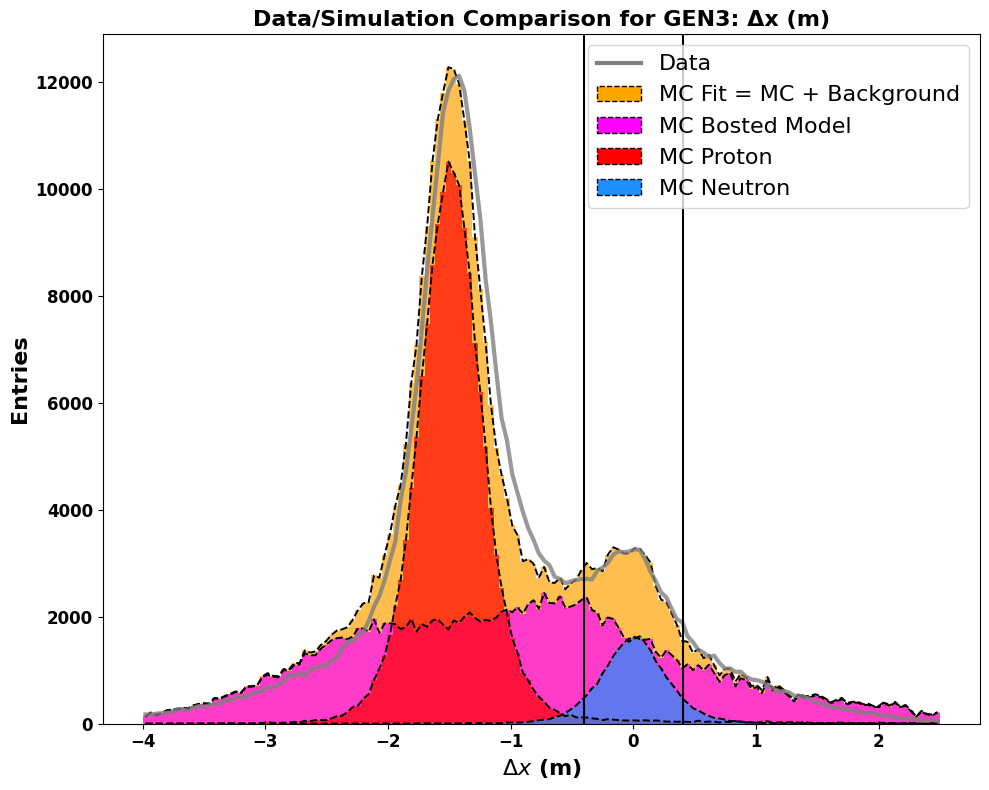

Total entries in fit: 356056.23058908375


In [497]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Style config
fig, ax = plt.subplots(figsize=(10, 8))
lw = 1.4
l = 3
fs = 16
fw = 'bold'
a = 1  # transparency for bars
bin_width = bin_centers[1] - bin_centers[0]

# Optional override
if config == "2":
    lw = 1
    l = 3
    typ = "4th Order Poly"
else:
    typ = "Background Data"



# --------- Total Fit ---------hatch='///',
ax.bar(bin_centers, total_fit, width=bin_width, align='center', alpha=0.7, color='orange', label="MC Fit = MC + Background")
ax.plot(bin_centers, total_fit, '--', color='black', linewidth=lw)

# --------- Inelastic ---------
ax.bar(bin_centers, bg_fit, width=bin_width, align='center', alpha=0.7, color='magenta', label="MC Inelastic")
ax.plot(bin_centers, bg_fit, '--', color='black', linewidth=lw)

# --------- Accidental ---------
#ax.bar(bin_centers, acc_fit, width=bin_width, align='center', alpha=0.5, color='magenta', label="MC Inelastic")
#ax.plot(bin_centers, acc_fit, '--', color='black', linewidth=lw)

# --------- Sim Proton ---------
ax.bar(bin_centers, sim_p_scaled, width=bin_width, align='center', alpha=0.7, color='red', label="MC Proton")
ax.plot(bin_centers, sim_p_scaled, '--', color='black', linewidth=lw)

# --------- Sim Neutron ---------
ax.bar(bin_centers, sim_n_scaled, width=bin_width, align='center', alpha=0.7, color='dodgerblue', label="MC Neutron")
ax.plot(bin_centers, sim_n_scaled, '--', color='black', linewidth=lw)

# --------- Data Line ---------
ax.bar(bin_centers, counts_data, width=bin_width, align='center', alpha=.01, color='white',label="Data")
ax.plot(bin_centers, counts_data, '-', color='grey',alpha=.8, linewidth=l, label='Data')

# --------- Custom Legend ---------
legend_elements = [
    Line2D([0], [0], color='grey', linewidth=3, linestyle='-', label='Data'),
    Patch(facecolor='orange', edgecolor='black', linestyle='--', label='MC Fit = MC + Background', alpha=a),
    Patch(facecolor='magenta', edgecolor='black', linestyle='--', label='MC Bosted Model', alpha=a),
    Patch(facecolor='red', edgecolor='black', linestyle='--', label='MC Proton', alpha=a),
    Patch(facecolor='dodgerblue', edgecolor='black', linestyle='--', label='MC Neutron', alpha=a)
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=fs)
# --------- Labels, ticks, etc. ---------
ax.set_title(f'Data/Simulation Comparison for GEN{config}: Δx (m)', fontsize=fs, fontweight=fw)
ax.set_xlabel(r'$\Delta x$ (m)', fontsize=fs, fontweight=fw)
ax.set_ylabel('Entries', fontsize=fs, fontweight=fw)
ax.tick_params(axis='both', labelsize=fs-4)
plt.xticks(fontsize=fs-4, fontweight=fw)
plt.yticks(fontsize=fs-4, fontweight=fw)
plt.tight_layout()
#plt.yscale("log")
plt.axvline(dxmin,color='black')
plt.axvline(dxmax,color='black')
# --------- Save and show ---------
#plt.savefig(f'../plots/DataSimPass{pas}GEN{config}.png')
plt.show()

# Optional: Check total counts
print("Total entries in fit:", np.sum(total_fit))


In [498]:
def compute_reduced_chi2(y_obs, y_fit, n_params):
    valid = y_obs > 0  # Ignore bins with no data
    residuals = y_obs[valid] - y_fit[valid]
    errors = np.sqrt(y_obs[valid] + (0.03 * y_obs[valid])**2)  # 2% systematic uncertainty

    chi2 = np.sum((residuals / errors)**2)

    dof = np.sum(valid) - n_params
    reduced_chi2 = chi2 / dof if dof > 0 else np.nan

    return reduced_chi2, chi2, dof
n_fit_params = 3  # Norm_overall, R_pn, Bg_norm — from 'from data' bg, so no bg shape params

reduced_chi2, chi2, dof = compute_reduced_chi2(counts_data, total_fit, n_fit_params)

print(f"χ² = {chi2:.2f}")
print(f"ndf = {dof}")
print(f"Reduced χ² = {reduced_chi2:.2f}")


χ² = 7406.34
ndf = 147
Reduced χ² = 50.38


In [499]:
def compute_log_likelihood(y_obs, y_fit):
    valid = y_obs > 0
    ratio = y_obs[valid] / y_fit[valid]
    ll = 2 * np.sum(y_obs[valid] * np.log(ratio))
    return ll


compute_log_likelihood(counts_data,total_fit)

-3486.6210423937227

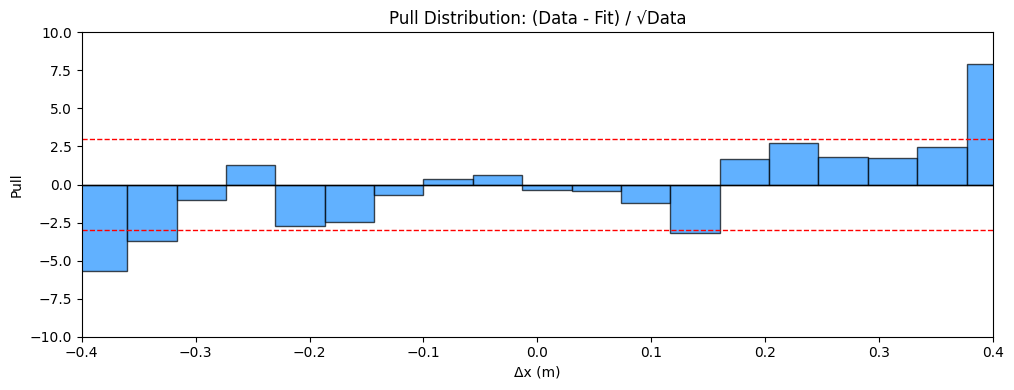

In [500]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pulls(x, data_counts, model_counts):
    # Only compute pulls where data > 0 to avoid divide-by-zero
    valid = data_counts > 0
    pulls = np.zeros_like(data_counts)
    pulls[valid] = (data_counts[valid] - model_counts[valid]) / np.sqrt(data_counts[valid])
    
    plt.figure(figsize=(10, 4))
    plt.axhline(0, color='black', lw=1)
    plt.axhline(3, color='red', ls='--', lw=1)
    plt.axhline(-3, color='red', ls='--', lw=1)
    plt.bar(x, pulls, width=(x[1] - x[0]), alpha=0.7, color='dodgerblue', edgecolor='black')
    plt.xlabel("Δx (m)")
    plt.ylabel("Pull")
    plt.title("Pull Distribution: (Data - Fit) / √Data")
    plt.tight_layout()
    plt.ylim(-10,10)
    plt.xlim(dxmin,dxmax)

    plt.show()
plot_pulls(bin_centers, counts_data, total_fit)

# Fit Fractions

In [501]:
# Find indices of bins within dxmin and dxmax
mask = (bin_centers >= dxmin) & (bin_centers <= dxmax)

# Sum the corresponding bin contents
N_p  = np.sum(sim_p_scaled[mask])
N_n  = np.sum(sim_n_scaled[mask])
N_bg = np.sum(bg_fit[mask])
if shape=="from data+acc":
    N_acc = np.sum(acc_fit[mask])
N_total = np.sum(total_fit[mask])


In [502]:
print(f"Total events in range ({dxmin}, {dxmax}):")
print(f"  Sim Proton:   {N_p:.2f}")
print(f"  Sim Neutron:  {N_n:.2f}")
print(f"  Background:   {N_bg:.2f}")
if shape=="from data+acc":
    print(f"  Accidental:   {N_acc:.2f}")

print(f"  Total:        {N_total:.2f}")


Total events in range (-0.4, 0.4):
  Sim Proton:   1232.81
  Sim Neutron:  20753.97
  Background:   31112.16
  Total:        53098.93


In [503]:
f_p=N_p/N_total
f_bg=N_bg/N_total
f_n=N_n/N_total
f_p_error=f_p * math.sqrt(1 / N_p + 1 / N_total)
f_bg_error=f_bg* math.sqrt(1 / N_bg + 1 / N_total)
f_n_error=f_n* math.sqrt(1 / N_n + 1 / N_total)

print(f"Fraction of events in range ({dxmin}, {dxmax}):")
print(f"Proton Fraction: {f_p:.2f}")
print(f"Background Fraction: {f_bg:.2f}")
print(f"Neutron Fraction: {f_n:.2f}")

Fraction of events in range (-0.4, 0.4):
Proton Fraction: 0.02
Background Fraction: 0.59
Neutron Fraction: 0.39


# W2 Spectra

In [504]:
neutronW2=neutroncut&Simdycut&Simdxcut
protonW2=protoncut&Simdycut&Simdxcut
bgW2=InSimdycut&InSimdxcut&goodsigmacut
dataW2=dycut&dxcut&coincut

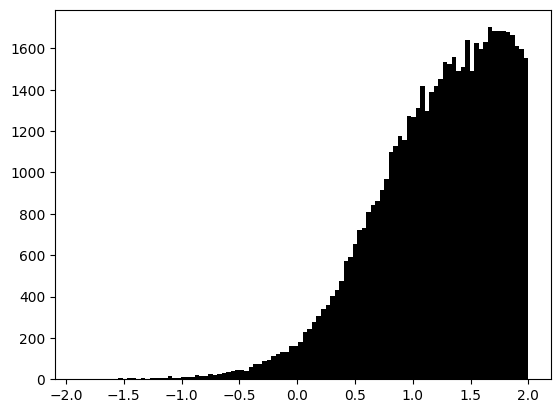

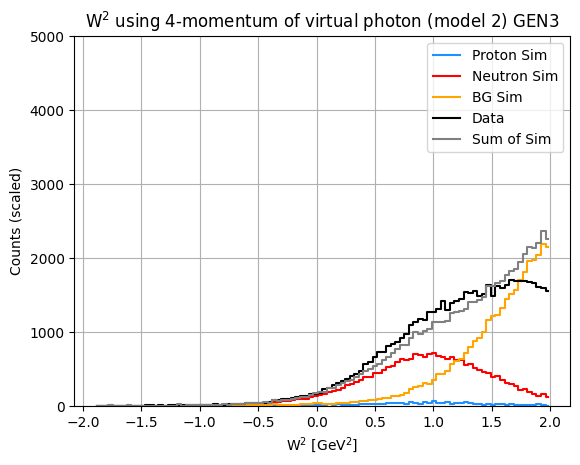

In [505]:

# Data (no scaling/normalization for raw data)
hist_data = plt.hist(generic["W2"][dataW2], bins=100, range=(W2min, W2max), color='black')
counts_data, bins_data = hist_data[0], hist_data[1]
scale=np.sum(counts_data)

# Sim proton
hist_p = plt.hist(genericSim["W2"][protonW2], bins=100,weights=weight[protonW2], range=(W2min, W2max), color='dodgerblue', alpha=0.5)
counts_p, bins_p = hist_p[0], hist_p[1]
norm_counts_p = counts_p / np.sum(counts_p)
scaled_counts_p = norm_counts_p *f_p

# Sim neutron
hist_n = plt.hist(genericSim["W2"][neutronW2], bins=100, weights=weight[neutronW2],range=(W2min, W2max), color='red', alpha=0.5)
counts_n, bins_n = hist_n[0], hist_n[1]
norm_counts_n = counts_n / np.sum(counts_n)
scaled_counts_n = norm_counts_n * (f_n)

# Background
hist_bg = plt.hist(genericSimIN["W2"][goodsigmacut], bins=100,weights=sigma[goodsigmacut], range=(W2min, W2max), color='orange', alpha=0.5)
counts_bg, bins_bg = hist_bg[0], hist_bg[1]
norm_counts_bg = counts_bg / np.sum(counts_bg)
scaled_counts_bg = norm_counts_bg * (f_bg)


# Bin centers
bin_centers_p = 0.5 * (bins_p[1:] + bins_p[:-1])
bin_centers_n = 0.5 * (bins_n[1:] + bins_n[:-1])
bin_centers_bg = 0.5 * (bins_bg[1:] + bins_bg[:-1])
bin_centers_data = 0.5 * (bins_data[1:] + bins_data[:-1])

# Plot
plt.figure()
plt.step(bin_centers_p, scaled_counts_p*scale, where='mid', color='dodgerblue', label='Proton Sim')
plt.step(bin_centers_n, scaled_counts_n*scale, where='mid', color='red', label='Neutron Sim')
plt.step(bin_centers_bg, scaled_counts_bg*scale, where='mid', color='orange', label='BG Sim')
plt.step(bin_centers_data, counts_data, where='mid', color='black', label='Data')
plt.step(bin_centers_data, scaled_counts_p*scale+scaled_counts_n*scale+scaled_counts_bg*scale, where='mid', color='grey', label='Sum of Sim')

plt.title(r"W$^2$ using 4-momentum of virtual photon (model 2) GEN3")
plt.xlabel(r"W$^2$ [GeV$^2$]")
plt.ylabel("Counts (scaled)")
plt.legend()
plt.grid(True)
plt.ylim(0, 5000)
plt.show()


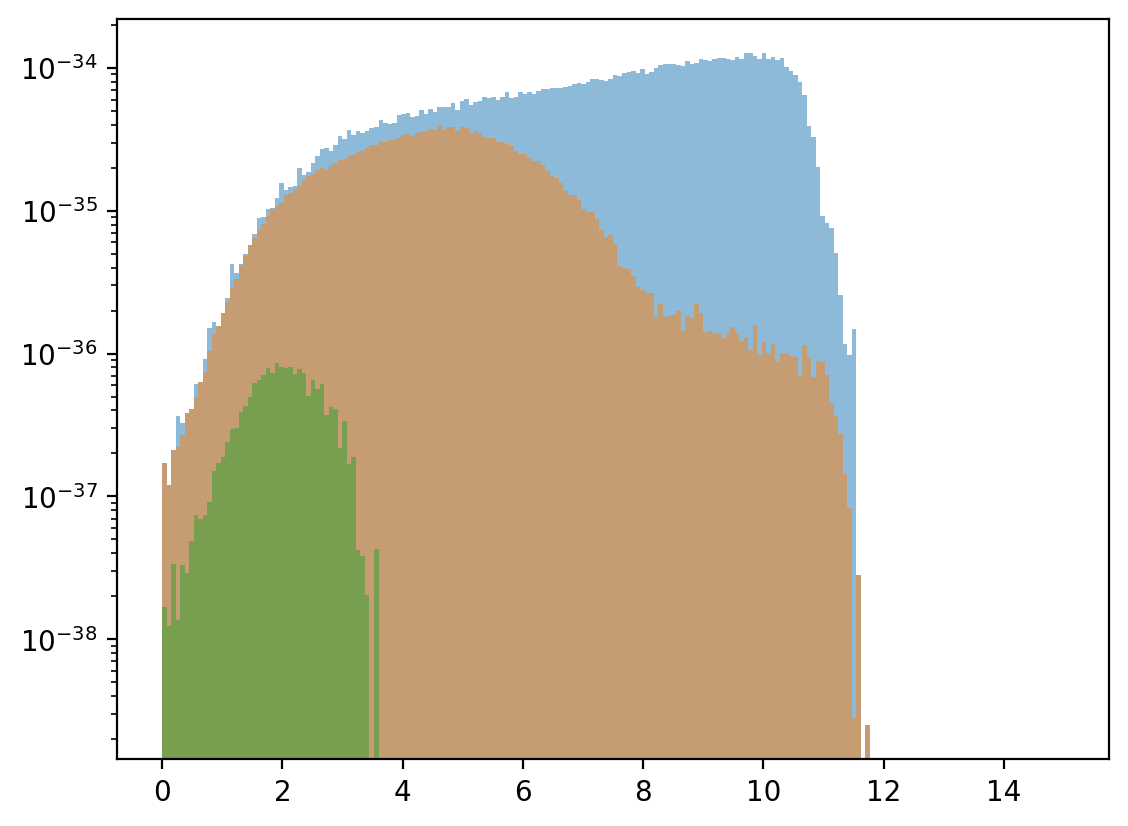

In [506]:
plt.figure(dpi=200)
d=plt.hist(genericSimIN["W2"],
           alpha=.5,bins=200,range=(0,15),weights=sigma)
d=plt.hist(genericSimIN["W2"][goodsigmacut],
           alpha=.5,bins=200,range=(0,15),weights=sigma[goodsigmacut])
d=plt.hist(genericSimIN["W2"][goodsigmacut&bgW2],
           alpha=.5,bins=200,range=(0,15),weights=sigma[goodsigmacut&bgW2])



plt.yscale("log")

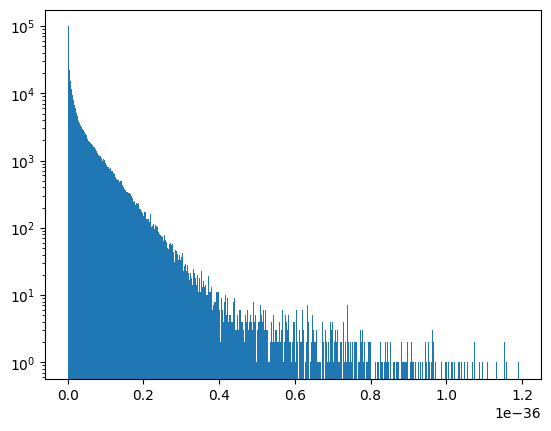

In [507]:
d=plt.hist(sigma,bins=500)
plt.yscale("log")

# Statistics Analysis

In [508]:
epmin=.7
epmax=1.3
stat_wcut=(generic["W2"]<W2max)&(generic["W2"]>W2min)
stat_dycut=(generic["dy"]<dymax)&(generic["dy"]>dymin)
stat_dxcut=(generic["dx"]<dxmax)&(generic["dx"]>dxmin)
stat_coincut=(generic["coin_time"]>coinmin)&(generic["coin_time"]<coinmax)

bbcalE=generic["eSH"]+generic["ePS"]
gemP=generic["trP"]
ep=bbcalE/gemP
stat_epcut=(ep>epmin)&(ep<epmax)


cuts = {
    "|dx| cut": stat_dxcut,
    "W2 cut": stat_wcut,
    "|dy| cut": stat_dycut,
    "Coincidence cut": stat_coincut,
    "BBCAL E/p cut": stat_epcut,
}

cutflow_data = []
total_events = len(stat_wcut)
mask_cumulative = np.ones(total_events, dtype=bool)

for name, this_cut in cuts.items():
    passed = np.sum(this_cut)
    mask_cumulative &= this_cut
    passed_cumulative = np.sum(mask_cumulative)
    cutflow_data.append({
        "Cut": name,
        "Passed This Cut": passed,
        "Cumulative Passed": passed_cumulative,
        "Rel Efficiency": passed / total_events,
        "Cum Efficiency": passed_cumulative / total_events
    })
import pandas as pd

df_cutflow = pd.DataFrame(cutflow_data)
print(df_cutflow.to_string(index=False))



            Cut  Passed This Cut  Cumulative Passed  Rel Efficiency  Cum Efficiency
       |dx| cut          4424829            4424829        0.186450        0.186450
         W2 cut          1335750             205553        0.056285        0.008661
       |dy| cut           961702              96548        0.040523        0.004068
Coincidence cut          7724542              58448        0.325491        0.002463
  BBCAL E/p cut         21416347              53721        0.902426        0.002264


# Corrections

### Accidentals

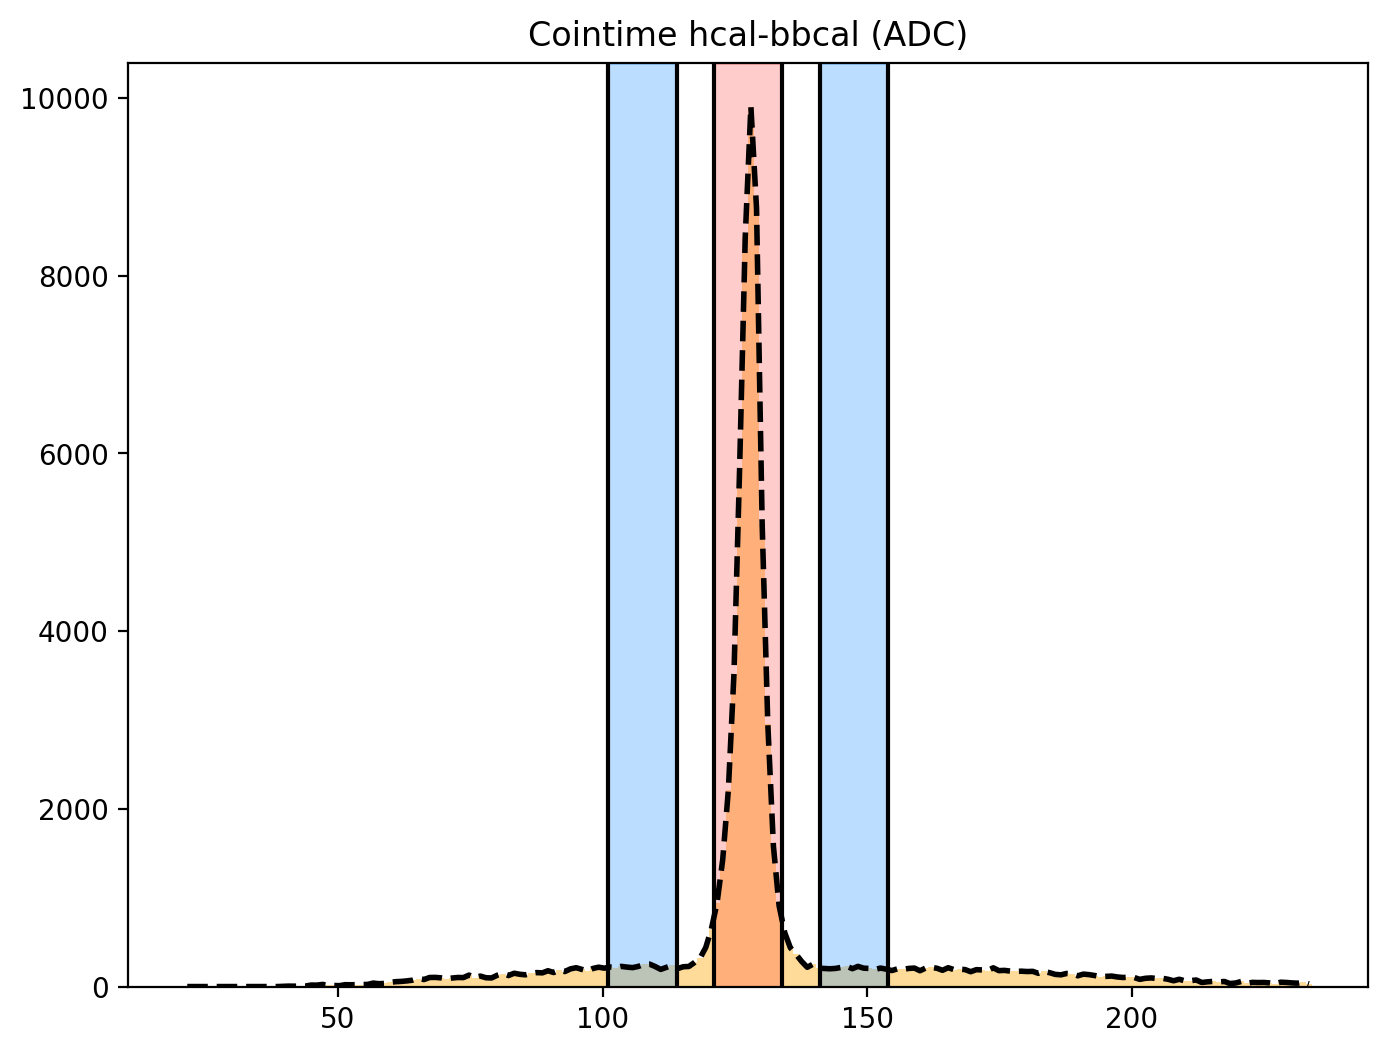

In [509]:


accBinRange=100
plt.figure(figsize=(8,6),dpi=200)
coin_hist,coin_edges=np.histogram(generic["coin_time"][accidentalcut],
                                  bins=200,range=(coinmin-accBinRange,coinmax+accBinRange))
coin_centers= (coin_edges[:-1] + coin_edges[1:]) / 2

d=plt.hist(generic["coin_time"][accidentalcut],
           bins=200,range=(coinmin-accBinRange,coinmax+accBinRange),color='orange',alpha=.4)
plt.plot(coin_centers, coin_hist,'--',color='black',linewidth=2)

plt.title("Cointime hcal-bbcal (ADC)")

plt.axvline(coinmin,color='black')
plt.axvline(coinmax,color='black')
plt.axvspan(coinmin, coinmax, color='red', alpha=0.2)

plt.axvline(coinmin+20,color='black')
plt.axvline(coinmax+20,color='black')
plt.axvspan(coinmin+20, coinmax+20, color='dodgerblue', alpha=0.3)

plt.axvline(coinmin-20,color='black')
plt.axvline(coinmax-20,color='black')
plt.axvspan(coinmin-20, coinmax-20, color='dodgerblue', alpha=0.3)

outside_coin_right=(coin_centers >= coinmin+20) & (coin_centers <= coinmax+20)
outside_coin_left=(coin_centers >= coinmin-20) & (coin_centers <= coinmax-20)
inside_coin=(coin_centers >= coinmin) & (coin_centers <= coinmax)

outside_number=(np.sum(coin_hist[outside_coin_right])+np.sum(coin_hist[outside_coin_left]))/2
inside_number=(np.sum(coin_hist[inside_coin]))

f_acc=outside_number/inside_number
f_acc_error=f_acc * math.sqrt(1 / outside_number + 1 / inside_number)

N_plus: 35049 N_minus: 33681
f_acc: 0.0501+=0.0010 A_acc: 0.019904+-0.0038


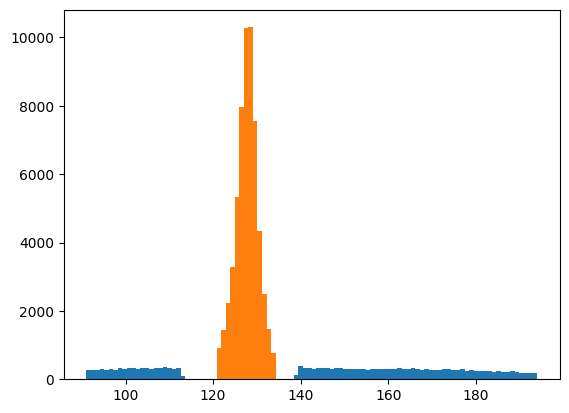

In [510]:
plus_coin_hist,plus_coin_edges=np.histogram(generic["coin_time"][accidentalcut&hpluscut],bins=100,range=(coinmin-30,coinmax+60))
minus_coin_hist,minus_coin_edges=np.histogram(generic["coin_time"][accidentalcut&hminuscut],bins=100,range=(coinmin-30,coinmax+60))
plt.hist(generic["coin_time"][wcut&dycut&dxcut&anticoincut],bins=100,
        range=(coinmin-30,coinmax+60))
plt.hist(generic["coin_time"][wcut&dycut&dxcut&coincut],bins=100,
        range=(coinmin-30,coinmax+60))
coin_plus_total = np.sum(plus_coin_hist)
coin_minus_total = np.sum(minus_coin_hist)

A_acc=(coin_plus_total-coin_minus_total)/(coin_plus_total+coin_minus_total)
A_acc_error=2*math.sqrt(coin_plus_total * coin_minus_total) / (coin_plus_total + coin_minus_total)**(3/2)
print(f"N_plus: {coin_plus_total} N_minus: {coin_minus_total}")
print(f"f_acc: {f_acc:.4f}+={f_acc_error:.4f} A_acc: {A_acc:.6f}+-{A_acc_error:.4f}")


### Inelastic

### Protons

<span style="font-size:1.5em;">
\begin{equation}
A_{\perp} = -\frac{G_{E}^n}{G_{M}^n} \cdot \frac{2\sqrt{\tau(\tau+1)}\tan{\frac{\theta}{2}}}{\left(\frac{G_{E}^n}{G_{M}^n}\right)^2 + \left(\tau + 2\tau(1+\tau)\tan^2\frac{\theta}{2}\right)}
\end{equation}
    </span>

<span style="font-size:3.5em;">
\begin{equation}
A_p=P_{^3He}P_{beam}P_p A_{\perp}(Q^2)
\end{equation}
    </span>

In [511]:
mup=2.793
Q2=CONFIG.Function_JSON("Q2",f"../config/cuts{config}.cfg")
def load_data(file_path):
    """
    Load the data from the given file path into a pandas DataFrame.
    """
    columns = ["Q2", "GEp/GD", "dGEp/GD", "dGEp_Par/GD", "GMp/mu_p/GD", "dGMp/mu_p/GD", "dGMp_Par/mu_p/GD"]
    data = pd.read_csv(file_path, delim_whitespace=True, comment='#', names=columns)
    return data
def find_closest_row(data, input_Q2):
    """
    Find the row in the data with the Q2 value closest to the input_Q2.
    """
    closest_row = data.iloc[(data['Q2'] - input_Q2).abs().argmin()]
    return closest_row
def main(input_Q2):
    file_path = '../DB/proton_lookup.dat'
    data = load_data(file_path)
    closest_row = find_closest_row(data, input_Q2)
    return closest_row
row=main(Q2)
R=np.round(row[1]/row[4]/mup,4)


#in GeV^2
m=.938
if config=="2":
    tau=Q2/(4*m**2)
    theta=29.5*pi/180
if config=="3":
    tau=Q2/(4*m**2)
    theta=36.5*pi/180
if config=="4":
    tau=Q2/(4*m**2)
    theta=35*pi/180

def Aperp(R, tau, theta):
    tan_half_theta = np.tan(np.radians(theta) / 2)
    numerator = -R * 2 * np.sqrt(tau * (tau + 1)) * tan_half_theta
    denominator = R**2 + (tau + 2 * tau * (1 + tau) * tan_half_theta**2)
    A_perp = numerator / denominator
    return A_perp

Ap=Aperp(R,tau,theta)
P_p=-.04 # seamus thesis
P_beam=CONFIG.Function_JSON("Pbeam",f"../config/cuts{config}.cfg")
P_target=CONFIG.Function_JSON("Ptarget",f"../config/cuts{config}.cfg")

A_p=Ap*P_p*P_beam*P_target/100/100
#Aphys_p=Ap*P_p*P_beam*P_target/100/100

In [512]:
print(f"f_p: {f_p:.4f}+={f_p_error:.4f} A_p: {A_p:.7f}")

f_p: 0.0232+=0.0007 A_p: 0.0000192


### Nitrogen

In [513]:
he3simfrac=np.sum(hdx_sim_n[0])/len(genericSim["dx"])


#the sim fraction
n2simfrac=135874/268774

n2overhe3counts=n2simfrac/he3simfrac/14 # divide by 14 because nitrogen molecule has 14 times n

n2overhe3counts

1.5*14*n2overhe3counts
98.5

nAtoms=100
nN2=.015
nHe3=.985

nN2*14/(14*nN2+nHe3)*n2overhe3counts

0.01999737181203096

### Pions 

# Raw Asymmetry

In [514]:
f_n

0.39085471352933654

In [515]:
N_minus_raw=len(np.where(helicity[fullcut]==-1)[0])
N_plus_raw=len(np.where(helicity[fullcut]==1)[0])

#SEAN JEFFAS KIN3: N_minus_raw=20336
#SEAN JEFFAS KIN3: N_plus_raw=21224
#SEAN JEFFAS fN=.29
#SEAN JEFFAS NEUTRONS: 12052.4
NEUTRONSSSSS=f_n*(N_minus_raw+N_plus_raw)

A_raw=(N_plus_raw-N_minus_raw)/(N_plus_raw+N_minus_raw)
A_raw_error=2*math.sqrt(N_plus_raw * N_minus_raw) / (N_plus_raw + N_minus_raw)**(3/2)
print(f"N_plus: {N_plus_raw} N_minus: {N_minus_raw}")
print(f"A_raw: {A_raw:.4f}+={A_raw_error:.4f}")

N_plus: 26120 N_minus: 24882
A_raw: 0.0243+=0.0044


In [516]:
NEUTRONSSSSS

19934.37209942322

# Beam and Target Polarimetry

Text(0, 0.5, 'Polarization Percentage(%)')

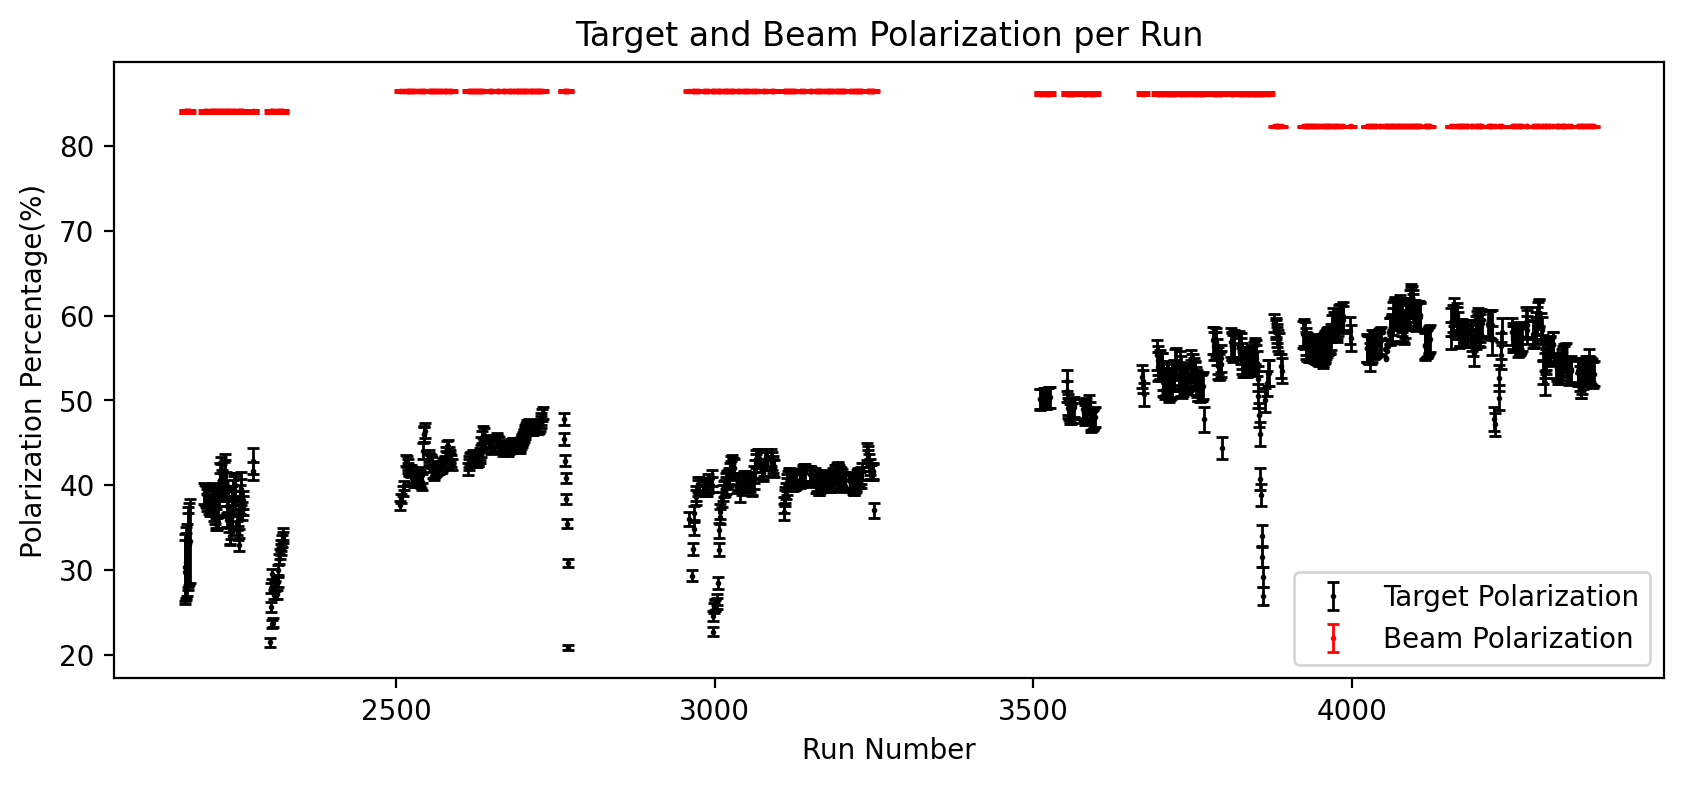

In [517]:
plt.figure(figsize=(10,4),dpi=200)
plt.errorbar(target_run_num,target_pol,target_polE,
             fmt='o',capsize=2,linewidth=1,
             color='black',markersize=1,
             label="Target Polarization")
plt.errorbar(target_run_num,beam_pol,beam_polE,
             fmt='o',capsize=2,linewidth=1,
             color='red',markersize=1,
             label="Beam Polarization")
plt.legend(loc="lower right")
#plt.ylim(40, 50)  # This *calls* the function and sets the y-axis limits
plt.title(f"Target and Beam Polarization per Run")
plt.xlabel("Run Number")
plt.ylabel("Polarization Percentage(%)")

# Run Summation

### Asymmetry per run

In [518]:
%%time
#helicity and runs with QE cuts
runnums = generic["runnum"][fullcut]>2165
pluscut=helicity[fullcut]==1
minuscut=helicity[fullcut]==-1
#Unique runs and compute asymmetry
unique_runnum, run_idx=np.unique(runnums, return_inverse=True)

N_plus_per_run=np.bincount(run_idx, weights=pluscut.astype(int))
N_minus_per_run=np.bincount(run_idx, weights=minuscut.astype(int))
A_raw_per_run=(N_plus_per_run-N_minus_per_run)/(N_plus_per_run+N_minus_per_run)
A_raw_error_per_run=2*(N_plus_per_run * N_minus_per_run)**(1/2) / (N_plus_per_run + N_minus_per_run)**(3/2)

CPU times: user 28 ms, sys: 22 µs, total: 28 ms
Wall time: 26.8 ms


In [519]:
runs_filtered = generic["runnum"][fullcut]
helicity_filtered = helicity[fullcut]

# Now apply the run number cut:
valid_runs = runs_filtered > 2165
runs_filtered = runs_filtered[valid_runs]
helicity_filtered = helicity_filtered[valid_runs]

pluscut = helicity_filtered == 1
minuscut = helicity_filtered == -1

unique_runnum, run_idx = np.unique(runs_filtered, return_inverse=True)
N_plus_per_run = np.bincount(run_idx, weights=pluscut.astype(int))
N_minus_per_run = np.bincount(run_idx, weights=minuscut.astype(int))
A_raw_per_run = (N_plus_per_run - N_minus_per_run) / (N_plus_per_run + N_minus_per_run)
A_raw_error_per_run = 2 * np.sqrt(N_plus_per_run * N_minus_per_run) / (N_plus_per_run + N_minus_per_run)**1.5


A_raw_error_per_run=A_raw_error_per_run[~np.isnan(A_raw_per_run)]
unique_runnum=unique_runnum[~np.isnan(A_raw_per_run)]
A_raw_per_run=A_raw_per_run[~np.isnan(A_raw_per_run)]

In [520]:
np.unique(generic["runnum"])

array([2506, 2507, 2511, 2512, 2516, 2517, 2518, 2519, 2520, 2521, 2522,
       2523, 2524, 2525, 2526, 2527, 2528, 2529, 2531, 2535, 2536, 2537,
       2539, 2540, 2541, 2542, 2543, 2544, 2545, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2568, 2569, 2570, 2571, 2572, 2574, 2575, 2576, 2577, 2578,
       2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2613, 2614, 2615,
       2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626,
       2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2637, 2638,
       2646, 2647, 2648, 2649, 2650, 2651, 2659, 2660, 2661, 2662, 2667,
       2668, 2669, 2670, 2671, 2674, 2676, 2677, 2678, 2679, 2680, 2681,
       2683, 2684, 2685, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694,
       2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705,
       2706, 2707, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 27

In [521]:
np.unique(runs_filtered)

array([2506, 2507, 2511, 2512, 2516, 2517, 2518, 2519, 2520, 2521, 2522,
       2523, 2524, 2525, 2526, 2527, 2528, 2529, 2531, 2535, 2536, 2537,
       2539, 2540, 2541, 2542, 2543, 2544, 2545, 2551, 2552, 2553, 2554,
       2555, 2556, 2557, 2558, 2559, 2560, 2561, 2562, 2563, 2564, 2565,
       2566, 2568, 2569, 2570, 2571, 2572, 2574, 2575, 2576, 2577, 2578,
       2579, 2580, 2581, 2583, 2584, 2585, 2586, 2587, 2613, 2614, 2615,
       2616, 2617, 2618, 2619, 2620, 2621, 2622, 2623, 2624, 2625, 2626,
       2627, 2628, 2629, 2630, 2631, 2632, 2633, 2634, 2635, 2637, 2638,
       2646, 2647, 2648, 2649, 2650, 2651, 2659, 2660, 2661, 2662, 2667,
       2668, 2669, 2670, 2671, 2674, 2676, 2677, 2678, 2679, 2680, 2681,
       2683, 2684, 2685, 2687, 2688, 2689, 2690, 2691, 2692, 2693, 2694,
       2695, 2696, 2697, 2698, 2699, 2700, 2701, 2702, 2703, 2704, 2705,
       2706, 2707, 2709, 2710, 2711, 2712, 2713, 2714, 2715, 2716, 2717,
       2718, 2719, 2720, 2721, 2722, 2723, 2724, 27

In [522]:
#plt.errorbar(unique_runnum,A_raw_per_run,A_raw_error_per_run)
#plt.ylim(-.1,.1)

### Polarizations per run

In [523]:
matching_pol_runs_i = np.searchsorted(target_run_num, unique_runnum)
P_beam_per_run = beam_pol[matching_pol_runs_i]/100
P_beamE_per_run = beam_polE[matching_pol_runs_i]/100
P_target_per_run = target_pol[matching_pol_runs_i]/100
P_targetE_per_run = target_polE[matching_pol_runs_i]/100



<ErrorbarContainer object of 3 artists>

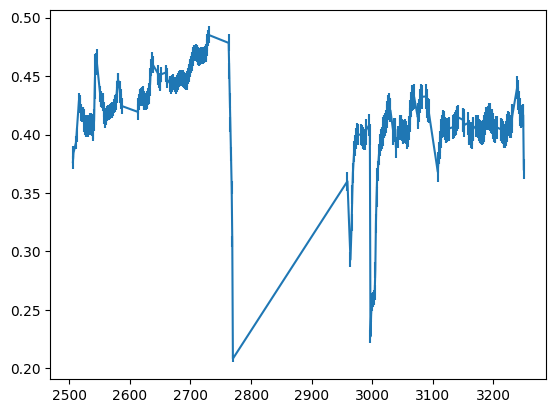

In [524]:
plt.errorbar(unique_runnum,P_target_per_run,P_targetE_per_run)

# A_Phys Calculation

In [525]:
f_n

0.39085471352933654

In [526]:
A_inelastic=.0035 
A_inelastic_error=.0005 

In [527]:
f_nitrogen=.0199
f_nitrogen_error=.0001

In [528]:
f_inelastic=f_bg-f_acc-f_nitrogen
f_inelastic_error=np.sqrt(f_acc_error**2+f_bg_error**2)

In [529]:
def weighted_avg(values, errors):
    weights = 1 / errors**2
    return np.sum(values * weights) / np.sum(weights)


In [530]:
fA=f_acc*A_acc + f_inelastic*A_inelastic + f_p*A_p
f=f_acc+f_nitrogen+f_p+f_inelastic


#####ERROR######
fA_error = np.sqrt(
    (f_acc * A_acc_error)**2 + (A_acc * f_acc_error)**2 +
    (f_inelastic * A_inelastic_error)**2 + (A_inelastic * f_inelastic_error)**2 +
    (f_p * 0)**2 + (A_p * f_p_error)**2
)

f_error = np.sqrt(f_acc_error**2 + f_nitrogen_error**2 + f_p_error**2 + f_inelastic_error**2)


P_neutron = 0.95 

#______________________________Statistical_________________________________________________________
A_corrected_per_run = (A_raw_per_run - fA) / (1 - f)
f_n=(1-f)
A_phys_per_run = A_corrected_per_run / (P_beam_per_run * P_target_per_run * P_neutron)
statistical_error_per_run=A_raw_error_per_run/(P_beam_per_run * P_target_per_run * P_neutron*(1-f))
#______________________________Statistical_________________________________________________________





weights = 1 / (statistical_error_per_run**2)
numerator = np.sum(A_phys_per_run * weights)
denominator = np.sum(weights)

numeratorPb = np.sum(P_beam_per_run * weights)
denominatorPb = np.sum(weights)

numeratorPt = np.sum(P_target_per_run * weights)
denominatorPt = np.sum(weights)

P_beam_avg=numeratorPb/denominatorPb
P_target_avg=numeratorPt/denominatorPt
P_beam_error_avg=P_beamE_per_run.mean()
P_target_error_avg=P_targetE_per_run.mean()


A_phys_weighted_avg = numerator / denominator
A_phys_stat_error=1/((denominator)**(1/2))



In [531]:
#Annoying Error Prop :)))))))))

\begin{equation}
A = \frac{A_r - \sum f_i A_i}{P (1 - \sum f_i)}
\end{equation}

\begin{equation}
\left( \frac{\partial A}{\partial A_r} \right)^2 \sigma_{A_r}^2 = \left( \frac{1}{P (1 - \sum f_i)} \right)^2 \sigma_{A_r}^2
\end{equation}

\begin{equation}
\left( \frac{\partial A}{\partial f_i} \right)^2 \sigma_{f_i}^2 =
\left( \frac{A P - \sum A_i + (A_r - \sum f_i A_i) P}{P^2 (1 - \sum f_i)^2} \right)^2 \sigma_{f_i}^2
\end{equation}

\begin{equation}
= \left( \frac{A P - \sum A_i}{P f_n} \right)^2 \sigma_{f_i}^2
\end{equation}

\begin{equation}
\left( \frac{\partial A}{\partial A_i} \right)^2 \sigma_{A_i}^2 =
\left( \frac{-\sum f_i}{P f_n} \right)^2 \sigma_{A_i}^2
\end{equation}

\begin{equation}
\left( \frac{\partial A}{\partial P} \right)^2 \sigma_P^2 =
\left( \frac{A_{\text{phys}}}{P^2} \right)^2 \sigma_P^2
\end{equation}

\begin{equation}
\sigma_A^2 = \sum_i \left( \frac{\partial A}{\partial x_i} \right)^2 \sigma_i^2
\end{equation}


In [532]:

f1=f_acc
sig_f1=f_acc_error

A1=A_acc
sig_A1=A_acc_error

f2=f_p
sig_f2=f_p_error

A2=A_p
sig_A2=0

f3=f_inelastic
sig_f3=f_inelastic_error

A3=A_inelastic
sig_A3=A_inelastic_error

f4=f_nitrogen
sig_f4=f_nitrogen_error

Pb=P_beam_avg
sig_Pb=P_beam_error_avg

Pt=P_target_avg
sig_Pt=.02

Pn=P_neutron

P_total=Pb*Pt*Pn
sig_P_total=((sig_Pb*Pt*Pn)**2+(sig_Pt*Pb*Pn)**2)**(1/2)

fn=1-f1-f2-f3-f4

A = A_phys_weighted_avg
P=P_total

In [533]:
dAdf1=((A*P-A1)/(P*fn)*sig_f1)**2
dAdf2=((A*P-A2)/(P*fn)*sig_f2)**2
dAdf3=((A*P-A3)/(P*fn)*sig_f3)**2
dAdf4=((A*P)/(P*fn)*sig_f4)**2

dAdA1=(f1/(P*fn)*sig_A1)**2
dAdA2=(f2/(P*fn)*sig_A2)**2
dAdA3=(f3/(P*fn)*sig_A3)**2

dAdP=(A/P**2*sig_P_total)**2

A_phys_sys_error=(dAdf1+dAdf2+dAdf3+dAdf4+dAdA1+dAdA2+dAdA3+dAdP)**(1/2)

In [534]:
A_phys_comb_error=np.sqrt(A_phys_sys_error**2+A_phys_stat_error**2)
if config=="2":
    A_phys_weighted_avg*=-1
print(f"A_phys_weighted_avg: {A_phys_weighted_avg:.5f}+-{A_phys_stat_error:.5f}+-{A_phys_sys_error:.5f}")
print(f"Combined Error: {A_phys_comb_error:.5f}")
#A_phys_sys_error=.01

A_phys_weighted_avg: 0.16537+-0.03295+-0.02290
Combined Error: 0.04013


# GEn Calculation

### Average Kinematics 

In [535]:
goodhel=(helicity[fullcut]==1) | (helicity[fullcut]==-1)

In [536]:
Q2_avg=np.mean(generic["Q2"][fullcut][goodhel])
etheta_avg=np.mean(generic["etheta"][fullcut][goodhel])

In [537]:
tau_avg=Q2_avg/(4*m**2)

In [538]:
epsilon_avg=1/(1+2*(1+tau_avg)*math.tan(etheta_avg/2)**2)

In [539]:
print(f"epsilon = {epsilon_avg}")
print(f"tau_avg = {tau_avg}")
print(f"Q2 = {Q2_avg}")

epsilon = 0.6242457424122971
tau_avg = 1.860718374965718
Q2 = 6.548567591613347


### Px and Pz

In [540]:
trPx = generic["trPx"][fullcut][goodhel]
trPy = generic["trPy"][fullcut][goodhel]
trPz = generic["trPz"][fullcut][goodhel]
ebeam = generic["ebeam"][fullcut][goodhel]

Px,Pz=compute_Px_Pz(trPx,trPy,trPz,ebeam,spintheta,spinphi)
Px_avg=np.mean(Px)
Pz_avg=np.mean(Pz)
print(f"Px: {Px_avg:.4f} Pz: {Pz_avg:.4f}")

Px: 0.9911 Pz: -0.0268


#  $G^n_E/G^n_M$

\begin{equation}
\begin{aligned}
A &= \frac{\bar{\epsilon}}{\bar{\tau}} A_{\text{phys}} \\
B &= \sqrt{\frac{2\bar{\epsilon}(1 - \bar{\epsilon})}{\bar{\tau}}} \, \bar{P}_x \\
C &= A_{\text{phys}} + \sqrt{1 - \bar{\epsilon}^2} \, \bar{P}_z
\end{aligned}
\tag{1}
\end{equation}


\begin{equation}
\begin{aligned}
- A_{\text{phys}} - \frac{\bar{\epsilon}}{\bar{\tau}} A_{\text{phys}} \Lambda^2 
&= \Lambda \sqrt{\frac{2\bar{\epsilon}(1 - \bar{\epsilon})}{\bar{\tau}}} \, \bar{P}_x + \sqrt{1 - \bar{\epsilon}^2} \, \bar{P}_z \\
0 &= \left( \frac{\bar{\epsilon}}{\bar{\tau}} A_{\text{phys}} \right) \Lambda^2 
+ \left( \sqrt{\frac{2\bar{\epsilon}(1 - \bar{\epsilon})}{\bar{\tau}}} \, \bar{P}_x \right) \Lambda 
+ \left( A_{\text{phys}} + \sqrt{1 - \bar{\epsilon}^2} \, \bar{P}_z \right) \\
0 &= A \Lambda^2 + B \Lambda + C
\end{aligned}
\tag{2}
\end{equation}


In [541]:
A=epsilon_avg/tau_avg*A_phys_weighted_avg
B=np.sqrt((2*epsilon_avg)*(1-epsilon_avg)/tau_avg)*Px_avg
C=A_phys_weighted_avg+np.sqrt(1-epsilon_avg**2)*Pz_avg

In [542]:
A_error = (epsilon_avg / tau_avg) * A_phys_comb_error
C_error = A_phys_comb_error

# Results
print(f"A = {A:.5f} ± {A_error:.5f}")
print(f"B = {B:.5f} (no propagated error)")
print(f"C = {C:.5f} ± {C_error:.5f}")

A = 0.05548 ± 0.01346
B = 0.49763 (no propagated error)
C = 0.14445 ± 0.04013


In [543]:
ratio=(-B+np.sqrt(B**2-4*A*C))/(2*A)

In [544]:
discriminant = B**2 - 4*A*C
ratio_error = np.sqrt(((C / (A * np.sqrt(discriminant)) + ratio / A)**2) * A_error**2 + (C_error**2 / discriminant))


In [545]:
print(f"GEn/GMn*muN: {ratio*muN:.5f}+-{ratio_error*muN:.5f}")

GEn/GMn*muN: 0.57372+--0.16519


# Tables

# Plots

In [546]:
ratio_error

0.08647237334172622

In [547]:
GEGM=ratio
GEGME=ratio_error

In [548]:
GEN2Data = {
    'Q2': [Q2_avg],
    'ExpName': ['GEn-II'],
    'R': [muN*GEGM ],
    'R_err': [abs(muN*GEGME)],
    'GEn': [0],   # assuming GEn and GEn_err are present in the file
    'GEn_err': [0]
}

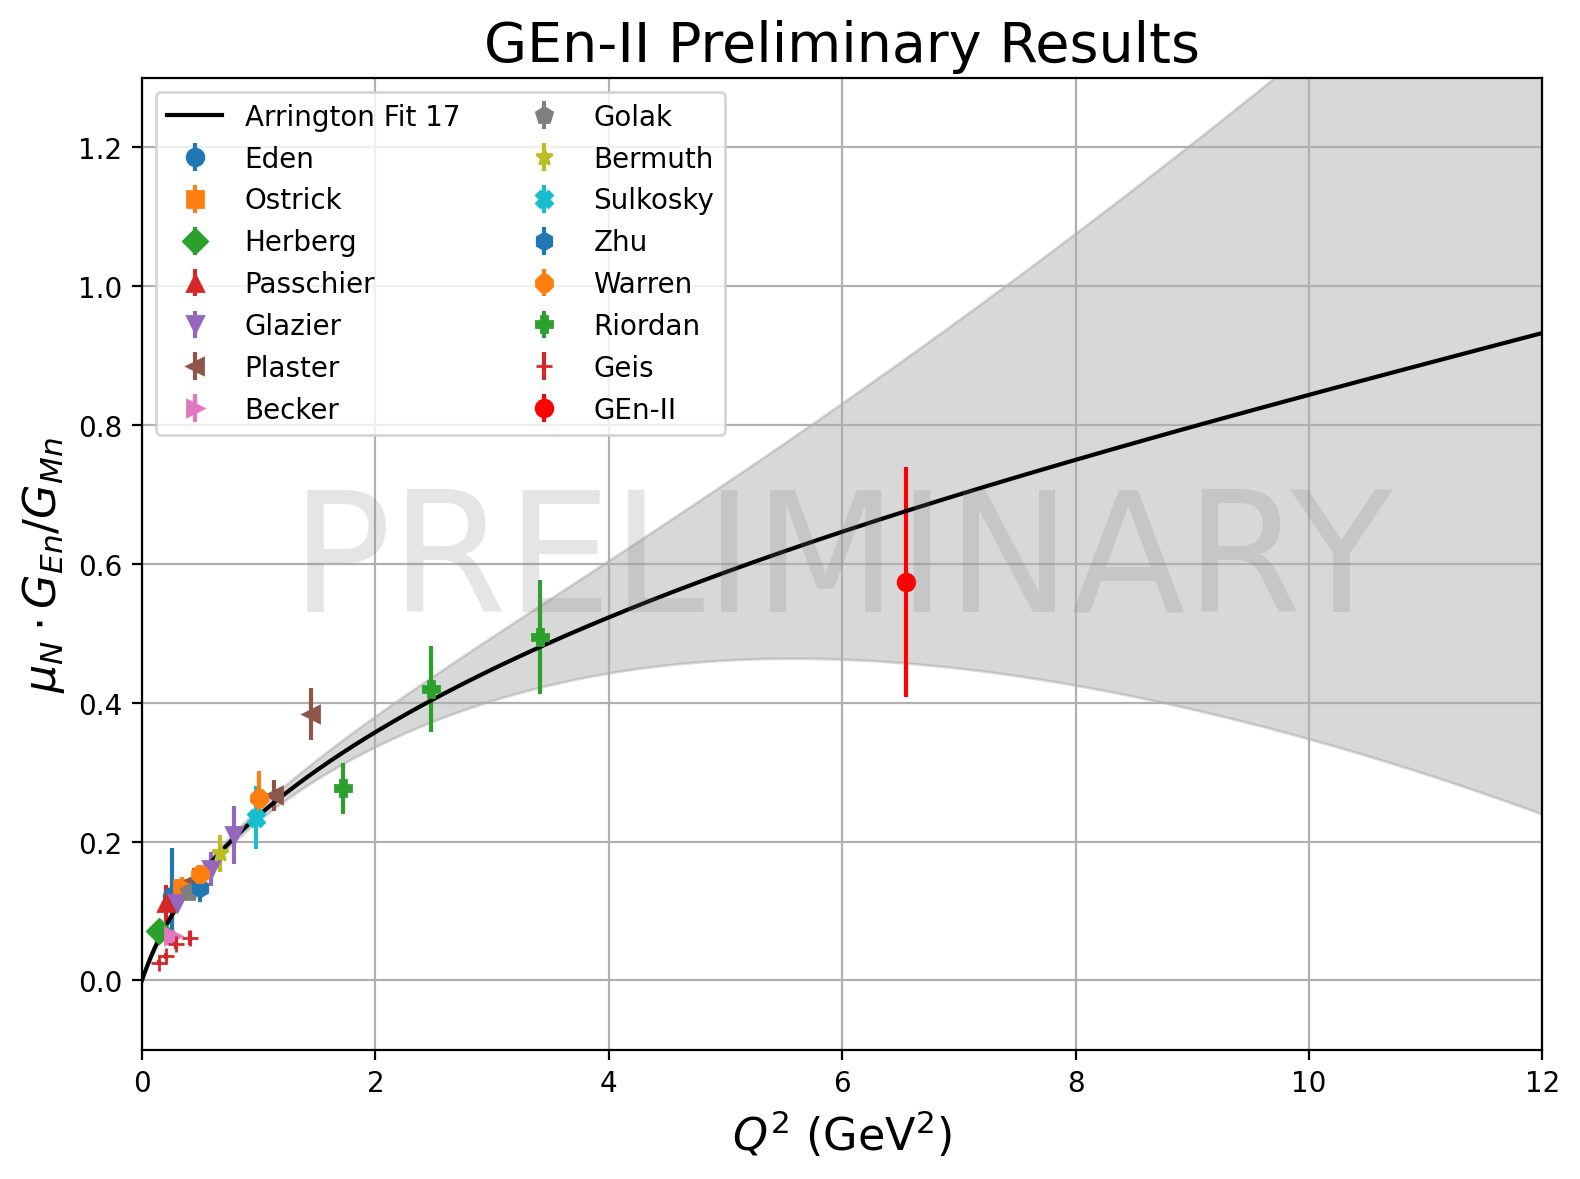

In [549]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from GETFF import Function_GETFF  # Assuming you have this imported somewhere

# Load theory Q2 and GEn/GD ratio
GEntheory = np.transpose(np.loadtxt('../DB/neutron_lookup.dat'))
Q2t = np.sort(GEntheory[0])

# Calculate GE/GM and uncertainties using GETFF
GEGD, GEGDE, GMGD, GMGDE = [], [], [], []
for q2 in Q2t:
    GEGD.append(Function_GETFF(3, q2)[0])
    GEGDE.append(Function_GETFF(3, q2)[1])
    GMGD.append(Function_GETFF(4, q2)[0])
    GMGDE.append(Function_GETFF(4, q2)[1])

GEGD = np.array(GEGD)
GEGDE = np.array(GEGDE)
GMGD = np.array(GMGD)
GMGDE = np.array(GMGDE)

# Error propagation: GE/GM with uncertainty
def eprop(GE, GEE, GM, GMM):
    R = GE / GM
    fractional_error = np.sqrt((GEE / GE)**2 + (GMM / GM)**2)
    return R, R * fractional_error

RatFit, RatFitE = eprop(GEGD, GEGDE, GMGD, GMGDE)

# Load world data
df = pd.read_csv("../DB/GEn_World_Data.csv")
mu_n = 1.91

# Setup plot
fig, ax = plt.subplots(figsize=(8, 6), dpi=200)
marker_styles = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'X', 'h', '8', 'P', '+', 'x', '|', '_']
experiments = df["Experiment"].unique()
markers = {exp: marker_styles[i % len(marker_styles)] for i, exp in enumerate(experiments)}

# Plot world data
for exp in experiments:
    subset = df[df["Experiment"] == exp]
    ax.errorbar(subset["Q2"], mu_n * subset["GEn"] / subset["GMn"],
                subset["RatE"], fmt=markers[exp], label=exp)
plt.errorbar(GEN2Data['Q2'],GEN2Data['R'],GEN2Data['R_err'],fmt='o',color='red',label='GEn-II')

# Plot fit and shaded error band
ax.plot(Q2t, RatFit, color='black', label='Arrington Fit 17')
ax.fill_between(Q2t, RatFit - RatFitE, RatFit + RatFitE, color='gray', alpha=0.3)

# Watermark and labels
ax.text(0.5, 0.5, 'PRELIMINARY', fontsize=60, color='gray',
        ha='center', va='center', alpha=0.2, transform=ax.transAxes)

ax.set_xlim(0, 12)
ax.set_ylim(-0.1, 1.3)
ax.grid(True)
ax.set_xlabel('$Q^2$ (GeV$^2$)', fontsize=16)
ax.set_ylabel(r'$\mu_N \cdot G_{En} / G_{Mn}$', fontsize=16)
ax.set_title('GEn-II Preliminary Results', fontsize=20)
ax.legend(loc='upper left', fontsize=10, ncol=2)
#plt.yscale("log")
plt.tight_layout()
plt.savefig("PrelimResults.pdf")
plt.show()
